Projet : Anticipez les besoins en consommation de bâtiments
Notebook : Exploration des données - feature engineering
Created by: Thomas Durand-Texte, Feb. 2023

# Import des packages et données
## import des packages

In [1]:
import os

import pandas as pd
from pandas import IndexSlice as idx

import pickle

import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
import datetime as dt
import scipy.stats as st

import missingno as msno

import pingouin as pg
from sklearn import linear_model
from sklearn import model_selection, metrics, preprocessing


import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [2]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    base_palette = sns.color_palette()
    sns.set_theme( 'notebook' , rc=rc )
    sns.set_palette( base_palette )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [3]:
def print_listdir( path=None, level=0, exclude=['ressources']) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0.ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- 2016_Building_Energy_Benchmarking_annexe.pkl
 |- |- 2016_Building_Energy_Benchmarking_location.pkl
 |- |- 2016_Building_Energy_Benchmarking_usetype.pkl
 |- |- other_data.pkl
 |- source
 |- |- 2016_Building_Energy_Benchmarking.csv
 |- |- 2016_Building_Energy_Benchmarking.pkl
 devel
 |- Exploration_v0 (copy).ipynb
 |- Exploration_v0.ipynb
 |- Modelisation_energy_v0.ipynb
 |- regressor.ipynb
 install_packages_venv.sh


1. Chargement des données
2. lower strings
3. compression et sauvegarde des données

In [4]:
path = 'data/source/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

if True:
    df = pd.read_csv( path + filename + '.csv' )
    for key in df.keys():
        if df[key].dtype == 'object':
            df[key] = df[key].str.lower()

    # suppression des colonnes vides (ici seulement comments)
    df.drop( columns=df.keys()[df.isna().sum(0) == len(df)], inplace=True )

    df.to_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
else:
    df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

del compression

In [5]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,nonresidential,hotel,mayflower park hotel,405 olive way,seattle,wa,98101.0,0659000030,7,downtown,47.61220,-122.33799,1927,1.0,12,88434,0,88434,hotel,hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,compliant,NaN,249.98,2.83
1,2,2016,nonresidential,hotel,paramount hotel,724 pine street,seattle,wa,98101.0,0659000220,7,downtown,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"hotel, parking, restaurant",hotel,83880.0,parking,15064.0,restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,compliant,NaN,295.86,2.86
2,3,2016,nonresidential,hotel,5673-the westin seattle,1900 5th avenue,seattle,wa,98101.0,0659000475,7,downtown,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,hotel,hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,compliant,NaN,2089.28,2.19
3,5,2016,nonresidential,hotel,hotel max,620 stewart st,seattle,wa,98101.0,0659000640,7,downtown,47.61412,-122.33664,1926,1.0,10,61320,0,61320,hotel,hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,compliant,NaN,286.43,4.67
4,8,2016,nonresidential,hotel,warwick seattle hotel (id8),401 lenora st,seattle,wa,98121.0,0659000970,7,downtown,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"hotel, parking, swimming pool",hotel,123445.0,parking,68009.0,swimming pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,compliant,NaN,505.01,2.88


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

# Nettoyage

## Initial Filtering : contexte = usage non résidentiel

value counts des 'BuildingType'

In [7]:
print(df.shape)
display( df['BuildingType'].value_counts() )

(3376, 45)


nonresidential          1460
multifamily lr (1-4)    1018
multifamily mr (5-9)     580
multifamily hr (10+)     110
sps-district k-12         98
nonresidential cos        85
campus                    24
nonresidential wa          1
Name: BuildingType, dtype: int64

Suppression des Mutlifamily

In [8]:
display( df['BuildingType'].value_counts() )

nonresidential          1460
multifamily lr (1-4)    1018
multifamily mr (5-9)     580
multifamily hr (10+)     110
sps-district k-12         98
nonresidential cos        85
campus                    24
nonresidential wa          1
Name: BuildingType, dtype: int64

initial DataFrame shape: (3376, 45)
DataFrame shape: (1668, 45)


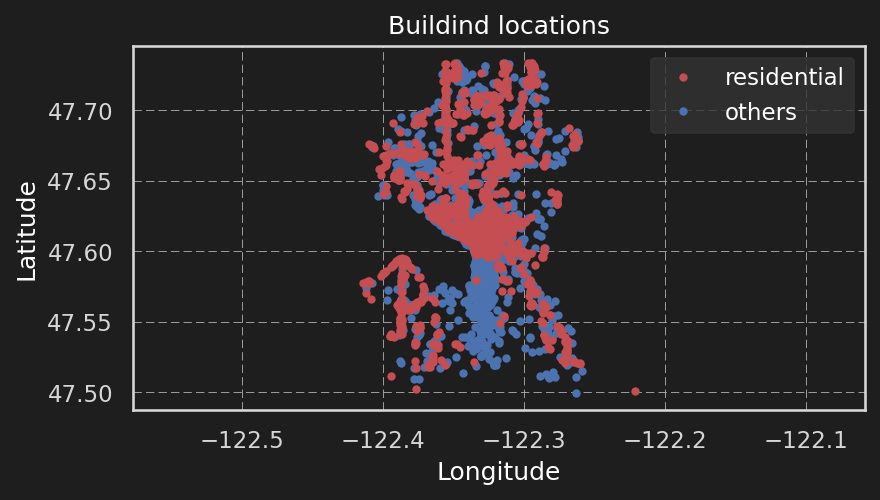

In [9]:
print('initial DataFrame shape:', df.shape )
sr_loc = df['BuildingType'].str.contains('multifamily')

fig, ax = plt.subplots( figsize=(16*cm,8*cm))
ax.plot( df.loc[sr_loc,'Longitude'], df.loc[sr_loc,'Latitude'], 'ro', markersize=3, label='residential', zorder=2 )
ax.plot( df.loc[~sr_loc,'Longitude'], df.loc[~sr_loc,'Latitude'], 'bo', markersize=3, label='others', zorder=1 )
ax.legend()
ax.axis('equal')
ax.set_title('Buildind locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

sr_loc = sr_loc[sr_loc]
df.drop( index=sr_loc.index, inplace=True )
print('DataFrame shape:', df.shape )

Définition d'une fonction pour déterminer les éléments correspondant à du `housing`

In [10]:
def is_housing( sr ):
    sr_loc = (sr.str.contains('hous|multifamily', na=False)) \
        & (~sr.str.contains('warehouse|courthouse', na=True))
    return sr_loc

Vérification et suppression à partir du `PrimaryPropertyType`

In [11]:
var = 'PrimaryPropertyType'
sr_loc = is_housing(df[var])
display( df.loc[sr_loc, var].value_counts() )
df.drop( index=sr_loc[sr_loc].index, inplace=True )
print('DataFrame shape:', df.shape )

low-rise multifamily    3
Name: PrimaryPropertyType, dtype: int64

DataFrame shape: (1665, 45)


1. Vérification et suppression pour le `LargestPropertyUseType`
2. Vérification des LargestPropertyUseType

In [12]:
vars = ['LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType']


sr_loc = is_housing( df[vars[0]] )

# sr_loc = is_housing( df[vars[1]] )
# for var in vars[2:]:
#     sr_loc = sr_loc | is_housing( df[var] )

# display( df['LargestPropertyUseType'].value_counts() )
# display( df['SecondLargestPropertyUseType'].value_counts() )
# display( df['ThirdLargestPropertyUseType'].value_counts() )

print('DataFrame shape:', df.shape )
display( f'housing find in {sr_loc.sum()} elements' )
display( df.loc[sr_loc, vars] )

df.drop( index=sr_loc[sr_loc].index, inplace=True )

print('DataFrame shape:', df.shape )

del vars, var

'housing find in 9 elements'

,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
164,multifamily housing,supermarket/grocery store,parking
1159,multifamily housing,office,parking
1839,multifamily housing,office,retail store
2314,multifamily housing,hotel,parking
2394,multifamily housing,parking,other
2748,multifamily housing,retail store,social/meeting hall
3003,multifamily housing,supermarket/grocery store,parking
3041,multifamily housing,parking,retail store
3087,multifamily housing,other - entertainment/public assembly,NaN


DataFrame shape: (1656, 45)


## Colonnes Outlier et DefaultData

In [13]:
def value_counts( sr ):
    value_counts = sr.value_counts()
    return pd.DataFrame( {'count': value_counts.values, 
                        '%':value_counts.values*(100/len(sr)) },
                        index=value_counts.index)

print('Outlier:')
display( value_counts( df['Outlier'] ) )
print('DefaultData:')
display( value_counts( df['DefaultData'] ) )

Outlier:


,count,%
low outlier,14,0.845411
high outlier,2,0.120773


DefaultData:


,count,%
False,1568,94.68599
True,88,5.31401


Mapping des "Outliers"

In [14]:
df['Outlier'] = df['Outlier'].map( {'low outlier':-1, 'high outlier':1}).fillna(0).astype('int')

## Vérifications doublons

In [15]:
print("Number of duplicated: {:}".format( df['OSEBuildingID'].duplicated().sum() ) )

Number of duplicated: 0


## Variables "inutiles"

Vérification des variables inutiles: création d'une liste "à supprimer" (suppression faite à la fin)

In [16]:
vars_to_delete = ['OSEBuildingID', 'PropertyName',
        'TaxParcelIdentificationNumber',
        'CouncilDistrictCode',
        'Address', 'ListOfAllPropertyUseTypes']
# df.drop( columns=vars, inplace=True )

In [17]:
vars_to_check = ['DataYear', 'City', 'State']

for var in vars_to_check:
    if not var in df.keys() :
        print( f'{var} not in DataFrame')
        continue
    sr = df[var].value_counts()
    display(sr)
    if len(sr) < 2:
        # df.drop( columns=var, inplace=True )
        vars_to_delete.append( var )
        print( f'{var} added to the drop list')

2016    1656
Name: DataYear, dtype: int64

DataYear added to the drop list


seattle    1656
Name: City, dtype: int64

City added to the drop list


wa    1656
Name: State, dtype: int64

State added to the drop list


## Variable liée à la date
Une variable "AgeOfBuilding(s)" est créée à partir des variables "DataYear" et "YearBuilt" 

In [18]:
df[['DataYear', 'YearBuilt']].info()
df['AgeOfBuilding(s)'] = df['DataYear'] - df['YearBuilt']
vars_to_delete.append( 'YearBuilt' )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 3375
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   DataYear   1656 non-null   int64
 1   YearBuilt  1656 non-null   int64
dtypes: int64(2)
memory usage: 38.8 KB


## Variable de localité
Seule la variable "Neighorhood" va être utilisée avec un hot encoding, "ZipCode", "Longitude" et "Latitude" seront supprimées.

In [19]:
vars_to_delete += ['ZipCode', 'Longitude', 'Latitude']

mask = 'Neighborhood'
display( df[mask].value_counts() )

downtown                  357
greater duwamish          346
magnolia / queen anne     150
lake union                146
northeast                 127
east                      118
northwest                  86
ballard                    70
north                      67
central                    55
southeast                  46
delridge                   46
southwest                  41
delridge neighborhoods      1
Name: Neighborhood, dtype: int64

mapping "delridge neighborhoods" $\rightarrow$ "delridge"

In [20]:
df.loc[ df[mask] == 'delridge neighborhoods', mask ] = 'delridge'
display( df[mask].value_counts() )

downtown                 357
greater duwamish         346
magnolia / queen anne    150
lake union               146
northeast                127
east                     118
northwest                 86
ballard                   70
north                     67
central                   55
delridge                  47
southeast                 46
southwest                 41
Name: Neighborhood, dtype: int64

On affiche les zones avec un scatter plot. Le package folium peut être utilsié pour afficher une carte interactive.

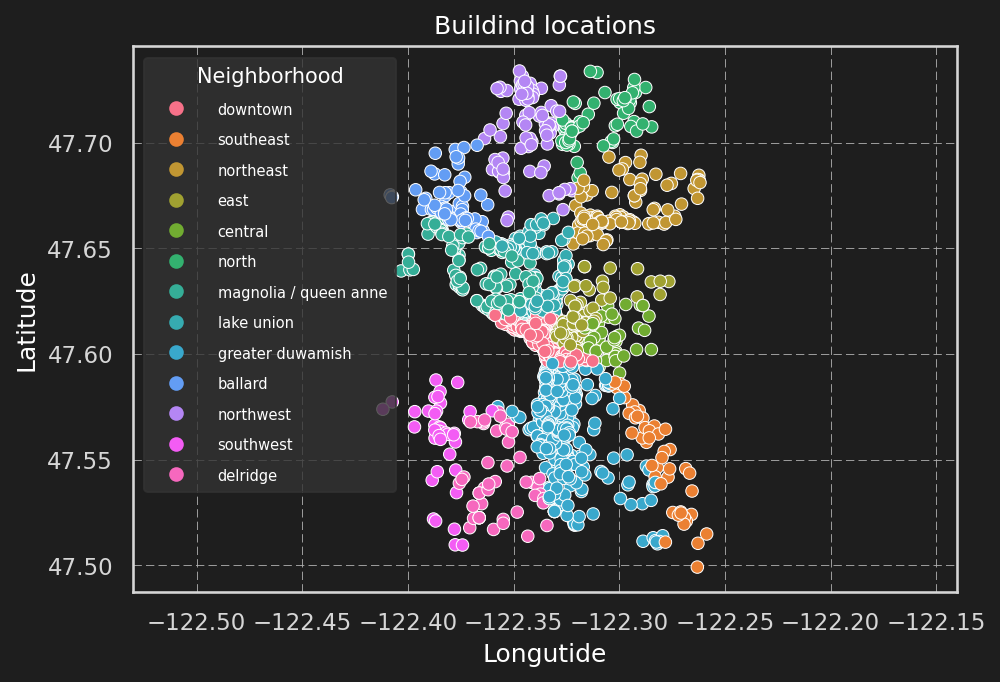

In [21]:
fig, ax = plt.subplots( figsize=(18*cm,12*cm))
scttr = sns.scatterplot( data=df, x='Longitude', y='Latitude', hue='Neighborhood', ax=ax )
ax.axis('equal')
ax.set_title('Buildind locations')
ax.set_xlabel('Longutide')
ax.set_ylabel('Latitude')

# for legend text
plt.setp(scttr.get_legend().get_texts(), fontsize='7') 
 
# for legend title
plt.setp(scttr.get_legend().get_title(), fontsize='10') 
plt.show()


## Recherche et gestion des NaN
### Détection des NaN
- Pour les Second & Third LargestPropertyUseType : uniquement 1 ou 2 utilisation du bâtiment $\rightarrow$ à gerer lors du hot encoding
- Pour le YearsENERGYSTARCertified : pas de certification
- Pour le ENERGYSTARscore : essayer de le modéliser ?

In [22]:
sum_isna = df.isna().sum()
print( 'sum isna > 0:' )
display( sum_isna[sum_isna > 0])

sum isna > 0:


ZipCode                              16
NumberofBuildings                     2
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        812
SecondLargestPropertyUseTypeGFA     812
ThirdLargestPropertyUseType        1312
ThirdLargestPropertyUseTypeGFA     1312
YearsENERGYSTARCertified           1558
ENERGYSTARScore                     566
SiteEUI(kBtu/sf)                      3
SiteEUIWN(kBtu/sf)                    3
SourceEUI(kBtu/sf)                    2
SourceEUIWN(kBtu/sf)                  2
SiteEnergyUse(kBtu)                   2
SiteEnergyUseWN(kBtu)                 3
SteamUse(kBtu)                        2
Electricity(kWh)                      2
Electricity(kBtu)                     2
NaturalGas(therms)                    2
NaturalGas(kBtu)                      2
TotalGHGEmissions                     2
GHGEmissionsIntensity                 2
dtype: int64

In [23]:
if False:
    ax = msno.bar( df )
    ax = msno.matrix( df.sort_values( by=['SecondLargestPropertyUseType','ThirdLargestPropertyUseType'] ) )

Il y a clairement des lignes avec un gros manque d'informations -> à enlever
- sur les energy : fillna(0) + sum(1) == 0 -> drop
- LargestPropertyUse : à remplir à partir du PrimaryPropertyType 

In [24]:
energy_keys = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
'SteamUse(kBtu)', 
'Electricity(kWh)', 'Electricity(kBtu)',
'NaturalGas(therms)', 'NaturalGas(kBtu)',
'TotalGHGEmissions', 'GHGEmissionsIntensity']

property_use_keys = [ 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']

others = ['NumberofBuildings']

keys = property_use_keys + others + energy_keys

sr_loc = df[keys].isna().sum(1) > 0
print('Entries with empty cells:')
display( df.loc[sr_loc, keys])

# DROP DATA WITHOUT ENERGY INFORMATION / CONSUMPTION
indexes = (df[energy_keys].fillna(0.).sum(1) == 0.)
indexes = indexes[indexes].index
print('indexes to drop:', indexes.values)
print('DataFrame shape:', df.shape)
df.drop( index=indexes , inplace=True )

print('Entries with empty cells (after drop):')
sr_loc = df[keys].isna().sum(1) > 0
display( df.loc[sr_loc, keys])
print('DataFrame shape:', df.shape)

Entries with empty cells:


,PrimaryPropertyType,ListOfAllPropertyUseTypes,LargestPropertyUseType,NumberofBuildings,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
304,other,"convention center, parking",convention center,1.0,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.00,0.00
353,self-storage facility,"fitness center/health club/gym, office, other ...",NaN,2.0,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,8.814520e+05,3007514.0,26899.582030,2689958.0,163.83,1.47
563,large office,"office, retail store",office,1.0,39.500000,NaN,128.000000,0.000000,5.177270e+06,NaN,0.0,1.427645e+06,4871126.0,14160.409180,1416041.0,109.16,0.83
578,small- and mid-sized office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1147,hotel,hotel,NaN,1.0,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,7.428464e+05,2534592.0,3624.875244,362488.0,36.92,0.60
2414,small- and mid-sized office,office,NaN,1.0,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,9.285260e+05,3168131.0,0.000000,0.0,22.09,0.46
2459,restaurant,restaurant,NaN,1.0,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,1.180853e+05,402907.0,4970.169922,497017.0,29.21,1.01
2670,mixed use property,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


indexes to drop: [  28  152  304  578  746 1361 2670]
DataFrame shape: (1656, 46)
Entries with empty cells (after drop):


,PrimaryPropertyType,ListOfAllPropertyUseTypes,LargestPropertyUseType,NumberofBuildings,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
353,self-storage facility,"fitness center/health club/gym, office, other ...",NaN,2.0,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,8.814520e+05,3007514.0,26899.582030,2689958.0,163.83,1.47
563,large office,"office, retail store",office,1.0,39.500000,NaN,128.000000,0.000000,5.177270e+06,NaN,0.0,1.427645e+06,4871126.0,14160.409180,1416041.0,109.16,0.83
1147,hotel,hotel,NaN,1.0,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,7.428464e+05,2534592.0,3624.875244,362488.0,36.92,0.60
2414,small- and mid-sized office,office,NaN,1.0,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,9.285260e+05,3168131.0,0.000000,0.0,22.09,0.46
2459,restaurant,restaurant,NaN,1.0,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,1.180853e+05,402907.0,4970.169922,497017.0,29.21,1.01


DataFrame shape: (1649, 46)


### Remplissage des NaN
On regarde les éléments sans LargestPropertyUseType

In [25]:
vars = ['PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
        'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)',
        'PropertyGFAParking', 'PropertyGFATotal' ]
sr_loc = (df['LargestPropertyUseType'].isna())
display( df.loc[sr_loc,vars])

,PrimaryPropertyType,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal
353,self-storage facility,"fitness center/health club/gym, office, other ...",NaN,NaN,111445,0,111445
1147,hotel,hotel,NaN,NaN,61721,0,61721
2414,small- and mid-sized office,office,NaN,NaN,48350,0,48350
2459,restaurant,restaurant,NaN,NaN,28800,0,28800


In [26]:
display( df.loc[ df['PrimaryPropertyType']=="self-storage facility", 'LargestPropertyUseType'].value_counts() )
display( df.loc[ df['PrimaryPropertyType'].str.contains('office'), 'LargestPropertyUseType'].value_counts() )

self-storage facility    27
Name: LargestPropertyUseType, dtype: int64

office            466
medical office     39
Name: LargestPropertyUseType, dtype: int64

À priori on peut replacer les valeurs manquantes de "LargestPropertyUseType(GFA)" par la "PrimaryPropertyType" / le "PropertyGFABuilding(s)".

Note: si présence de "office" dans le "PrimaryPropertyType", alors la valeur est "office" (pas de distinctions pour les "LargestPropertyUseType")

In [27]:
for index in sr_loc[sr_loc].index:
    Primary = df.at[index, 'PrimaryPropertyType']
    df.at[index, 'LargestPropertyUseTypeGFA'] = df.at[index, 'PropertyGFABuilding(s)']
    if 'office' in Primary:
        df.at[index, 'LargestPropertyUseType'] = 'office'
        continue
    df.at[index, 'LargestPropertyUseType'] = Primary

On vérifie le résultat:

In [28]:
display( df.loc[sr_loc,vars] )

,PrimaryPropertyType,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal
353,self-storage facility,"fitness center/health club/gym, office, other ...",self-storage facility,111445.0,111445,0,111445
1147,hotel,hotel,hotel,61721.0,61721,0,61721
2414,small- and mid-sized office,office,office,48350.0,48350,0,48350
2459,restaurant,restaurant,restaurant,28800.0,28800,0,28800


In [29]:
sum_isna = df.isna().sum()
print( 'sum isna > 0:' )
display( sum_isna[sum_isna > 0])

sum isna > 0:


ZipCode                              16
SecondLargestPropertyUseType        806
SecondLargestPropertyUseTypeGFA     806
ThirdLargestPropertyUseType        1305
ThirdLargestPropertyUseTypeGFA     1305
YearsENERGYSTARCertified           1551
ENERGYSTARScore                     560
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
dtype: int64

Remplissage du ZipCode à partir de la longitude et de la latitude: toutes les données étant à Seattle, les variables `Longitude` et `Latitude` peuvent être utilisée comme (`x`,`y`).

Si il y avait plus d'écarts entre les positions, possibilité d'utilisé le package `haversine`.

In [30]:
sr_loc = df['ZipCode'].isna()
for index in sr_loc[sr_loc].index:
    x,y = df.loc[index, ['Longitude', 'Latitude']].values
    for value in df['Longitude']:
        if isinstance( value, str):
            print('value:', value)
    df['Longitude'].values-x
    df['Latitude'].values-y
    argsort = ((df['Longitude'].values-x)**2 + (df['Latitude'].values-y)**2).argsort()
    for i in argsort[1:]: # neglect the first as it corresponds to the current index
        if np.isnan( df['ZipCode'].iloc[i] ) :
            continue
        df.at[index, 'ZipCode'] = df['ZipCode'].iloc[i]
        break 
    # print('\nx,y:', x,y, '\nx2,y2:', df[['Longitude','Latitude']].iloc[i,:].values )

sum_isna = df.isna().sum()
print( 'After procees sum isna > 0:' )
display( sum_isna[sum_isna > 0])

After procees sum isna > 0:


SecondLargestPropertyUseType        806
SecondLargestPropertyUseTypeGFA     806
ThirdLargestPropertyUseType        1305
ThirdLargestPropertyUseTypeGFA     1305
YearsENERGYSTARCertified           1551
ENERGYSTARScore                     560
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
dtype: int64

## Recherches à partir des variables "DefaultData" et "ComplianceStatus"

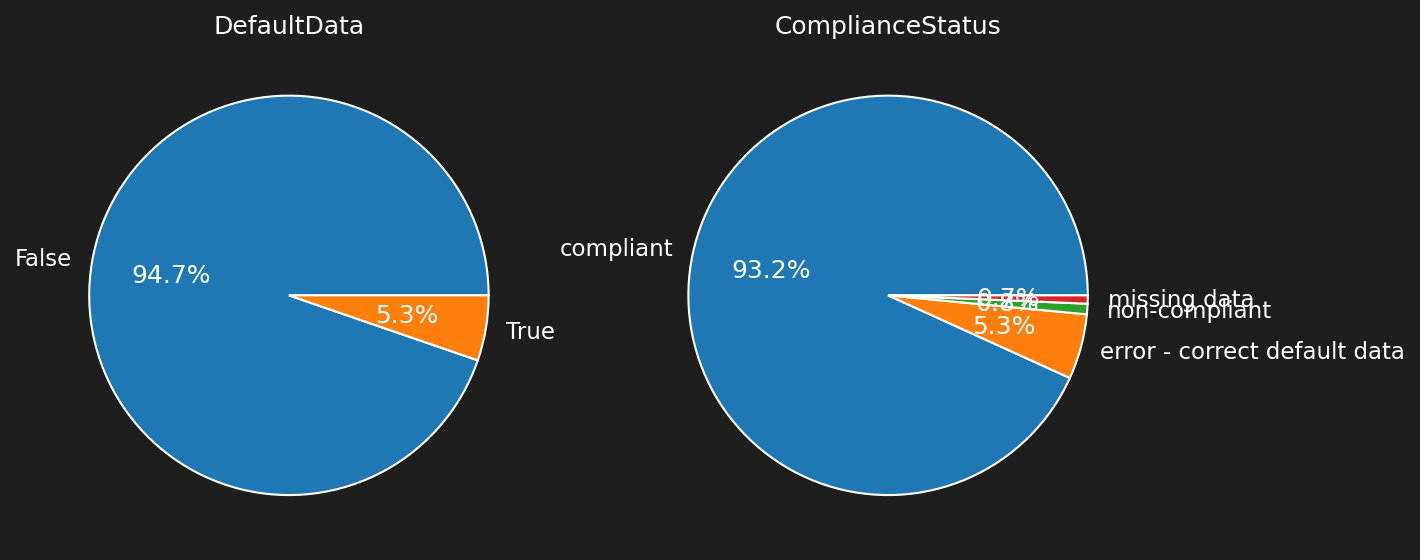

In [31]:
fig, axs = plt.subplots( ncols=2, figsize=(24*cm,12*cm))
for ax, key in zip( axs, ['DefaultData', 'ComplianceStatus']):
    df[key].value_counts(normalize=True).plot( kind='pie', ax=ax, autopct='%.1f%%' )
    ax.set_title( key)
    ax.set_ylabel('')

On peut se poser la question de l'intérêt de supprimer certaines entrées.

Dans l'idée, les données seront mesurées pour les nouveaux bâtiments, donc autant enlever les entrées avec des valeurs imputées.

In [32]:
sr_loc = df['DefaultData'] | ( df['ComplianceStatus'].str.contains( '|'.join( ['missing', 'error'] ) ) )
df.drop( index=sr_loc[sr_loc].index ,inplace=True )

***
# Vérifications des données d'entrée

In [33]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHG

## Value_counts des variables

In [34]:
print('DataFrame shape:', df.shape )

DataFrame shape: (1551, 46)


In [35]:
vars = ['BuildingType', 'PrimaryPropertyType',
       'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType',
       ]
for var in vars:
    print( f'{var} value_counts:')
    display( df[var].value_counts() )

BuildingType value_counts:


nonresidential        1435
nonresidential cos      82
campus                  23
sps-district k-12       10
nonresidential wa        1
Name: BuildingType, dtype: int64

PrimaryPropertyType value_counts:


small- and mid-sized office    289
other                          248
warehouse                      185
large office                   172
mixed use property             104
retail store                    86
hotel                           76
worship facility                71
distribution center             53
k-12 school                     51
supermarket / grocery store     40
medical office                  39
self-storage facility           28
university                      24
residence hall                  21
senior care community           20
refrigerated warehouse          12
restaurant                      12
hospital                        10
laboratory                      10
Name: PrimaryPropertyType, dtype: int64

Neighborhood value_counts:


downtown                 352
greater duwamish         331
magnolia / queen anne    144
lake union               141
northeast                118
east                     114
northwest                 78
ballard                   63
north                     59
central                   47
delridge                  41
southwest                 32
southeast                 31
Name: Neighborhood, dtype: int64

NumberofBuildings value_counts:


1.0      1447
0.0        52
2.0        14
3.0        12
5.0         7
4.0         4
6.0         4
14.0        2
8.0         2
27.0        1
11.0        1
9.0         1
7.0         1
23.0        1
10.0        1
111.0       1
Name: NumberofBuildings, dtype: int64

NumberofFloors value_counts:


1     425
2     355
3     242
4     138
5     101
6      81
7      34
8      22
10     18
11     18
0      16
14      9
12      9
9       8
13      7
15      6
42      5
19      5
17      4
29      3
22      3
21      3
23      3
16      3
18      3
20      3
24      3
25      3
33      3
34      2
36      2
41      2
56      1
28      1
76      1
27      1
46      1
30      1
47      1
55      1
63      1
37      1
49      1
99      1
Name: NumberofFloors, dtype: int64

LargestPropertyUseType value_counts:


office                                                  492
non-refrigerated warehouse                              197
other                                                    98
retail store                                             94
hotel                                                    77
worship facility                                         71
distribution center                                      54
k-12 school                                              51
supermarket/grocery store                                41
medical office                                           41
other - recreation                                       31
parking                                                  30
self-storage facility                                    28
college/university                                       24
residence hall/dormitory                                 22
other - entertainment/public assembly                    21
senior care community                   

SecondLargestPropertyUseType value_counts:


parking                                                 332
office                                                  165
retail store                                             82
other                                                    44
restaurant                                               29
non-refrigerated warehouse                               28
fitness center/health club/gym                           16
data center                                              13
multifamily housing                                      12
other - services                                         11
laboratory                                                8
medical office                                            8
supermarket/grocery store                                 7
distribution center                                       7
bank branch                                               7
other - entertainment/public assembly                     6
k-12 school                             

ThirdLargestPropertyUseType value_counts:


office                                                  49
retail store                                            45
parking                                                 41
other                                                   38
restaurant                                              31
data center                                             14
non-refrigerated warehouse                              14
multifamily housing                                     12
swimming pool                                           10
medical office                                           9
food service                                             8
pre-school/daycare                                       8
social/meeting hall                                      7
bank branch                                              5
other - restaurant/bar                                   5
financial office                                         4
fitness center/health club/gym                          

## Diverses vérifications

### Number of floors
On regarde les number of floors pour voir si il y a des valeurs aberrantes

Text(2100000.0, 82, 'valeur aberrante :\nseattle chinese baptist church')

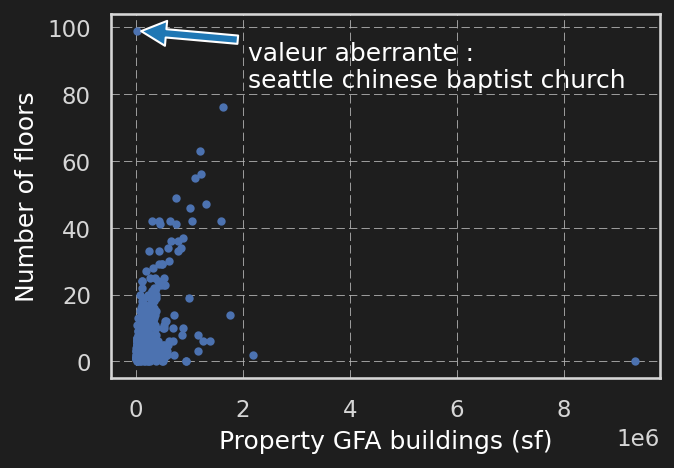

In [36]:
X, Y = 'PropertyGFABuilding(s)', 'NumberofFloors'

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( df[X], df[Y], 'bo', markersize=3 )

ax.set_ylabel( 'Number of floors' )
ax.set_xlabel( 'Property GFA buildings (sf)' )

index_100 = df[Y] > 90
index_100 = index_100[index_100].index.values[0]

ax.annotate( 'valeur aberrante :\n{:}'.format( 
                df.at[index_100, 'PropertyName'] ),
                xy=[0, 99], xytext=[2.1e6, 82],# ha='left', va='center',
                arrowprops=dict(shrink=0.05) )

On assigne la valeur la plus utilisée pour NumberofFloors: 1, sachant que la surface est relativement faible.

In [37]:
df.at[index_100, Y] = 1

### Number of Buildings

Certains `NumberofBuildings` sont particulièrement élevés, mais à priori OK.

In [38]:
mask = 'NumberofBuildings'
df.loc[ df[mask] > 5, :].sort_values( by=mask )

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,AgeOfBuilding(s)
124,198,2016,nonresidential,hospital,seattle children's hospital main campus,4800 sand point way ne,seattle,wa,98105.0,2982800005,4,northeast,47.662310,-122.281460,1953,6.0,10,879000,0,879000,hospital (general medical & surgical),hospital (general medical & surgical),879000.0,NaN,NaN,NaN,NaN,NaN,10.0,288.799988,293.200012,578.200012,576.599976,2.538325e+08,2.577642e+08,0.0,3.389250e+07,115641210.0,1.381912e+06,138191238.0,False,compliant,0,8145.52,9.27,63
167,268,2016,nonresidential,hospital,swedish cherry hill,500 17th ave,seattle,wa,98122.0,7942600331,3,central,47.607050,-122.309660,1990,6.0,5,597519,0,597519,"hospital (general medical & surgical), parking",hospital (general medical & surgical),601615.0,parking,48607.0,NaN,NaN,NaN,34.0,238.399994,244.800003,454.399994,459.200012,1.434230e+08,1.472991e+08,0.0,1.722008e+07,58754927.0,8.466809e+05,84668094.0,False,compliant,0,4906.33,8.21,26
364,516,2016,nonresidential,other,aurora shopping center,13201 aurora avenue north,seattle,wa,98133.0,1926049215,5,northwest,47.725460,-122.346590,1964,6.0,1,111900,0,111900,"parking, strip mall",strip mall,124231.0,parking,0.0,NaN,NaN,NaN,NaN,79.000000,81.099998,190.500000,193.000000,9.814820e+06,1.007999e+07,0.0,1.872845e+06,6390148.0,3.424670e+04,3424670.0,False,compliant,0,226.43,2.02,52
2901,27389,2016,nonresidential,small- and mid-sized office,leschi lakecenter,120 lakeside,seattle,wa,98122.0,4114601145,3,central,47.602070,-122.284810,1956,6.0,2,75868,0,75868,"non-refrigerated warehouse, office, restaurant...",office,50379.0,restaurant,12622.0,retail store,6662.0,NaN,NaN,47.500000,47.500000,149.199997,149.199997,3.605750e+06,3.605750e+06,0.0,1.056785e+06,3605750.0,0.000000e+00,0.0,False,compliant,0,25.14,0.33,60
618,828,2016,nonresidential,hospital,swedish first hill,747 broadway,seattle,wa,98122.0,1978201096,3,east,47.608951,-122.322402,1994,7.0,14,1765970,0,1765970,"hospital (general medical & surgical), parking",hospital (general medical & surgical),1639334.0,parking,441551.0,NaN,NaN,NaN,54.0,177.899994,180.500000,377.000000,378.399994,2.916144e+08,2.959299e+08,134943456.0,4.084256e+07,139354828.0,1.731612e+05,17316120.0,False,compliant,0,12307.16,6.97,22
1672,23071,2016,nonresidential,hospital,main hospital - all wings,facilities management ms: b-120,seattle,wa,98133.0,3026049130,5,northwest,47.714250,-122.336890,1966,8.0,1,415632,0,415632,"hospital (general medical & surgical), parking",hospital (general medical & surgical),483520.0,parking,266833.0,NaN,NaN,NaN,85.0,204.699997,207.500000,400.200012,402.100006,9.896078e+07,1.003283e+08,0.0,1.256277e+07,42864158.0,5.609661e+05,56096612.0,False,compliant,0,3278.11,7.89,50
3168,49705,2016,nonresidential cos,other,magnuson,7400 sand point way ne,seattle,wa,98115.0,0225049062,4,northeast,47.682120,-122.263300,1929,8.0,0,502030,0,502030,other - recreation,other - recreation,564258.0,NaN,NaN,NaN,NaN,NaN,NaN,32.700001,36.599998,69.000000,74.300003,1.847034e+07,2.067295e+07,0.0,2.743225e+06,9359884.0,9.110455e+04,9110455.0,False,compliant,0,549.11,1.09,87
170,276,2016,nonresidential,hospital,harborview medical center,325 9th ave.,seattle,wa,98104.0,8590900220,3,east,47.603990,-122.323770,20

### PorpertyGFA
Présence d'outliers ?

`university of washington - seattle campus` et `entire campus` correspondent à des valeurs `atypique` mais non aberrantes

In [39]:
mask = 'PropertyGFATotal'
describe = df[mask].describe()
print(mask)
display(describe)

print('Q3 + 1.5*IQ = {:.3e}'.format( describe['75%'] 
            + 1.5*(describe['75%']-describe['25%']) ) )

df_sorted = df.sort_values( by=mask, ascending=False ).iloc[:5,:]
display( df_sorted )

PropertyGFATotal


count    1.551000e+03
mean     1.205977e+05
std      3.050729e+05
min      1.128500e+04
25%      2.880400e+04
50%      4.813900e+04
75%      1.077510e+05
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64

Q3 + 1.5*IQ = 2.262e+05


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,AgeOfBuilding(s)
3274,49967,2016,campus,university,university of washington - seattle campus,ne 45th st & brooklyn ave,seattle,wa,98105.0,1625049001,4,northeast,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156,college/university,college/university,9320156.0,NaN,NaN,NaN,NaN,NaN,NaN,93.800003,0.000000,246.600006,0.000000,873923712.0,0.0,8.498524e+07,192577488.0,657074389.0,0.00000,0.0,False,compliant,0,11140.56,1.20,116
1494,22062,2016,campus,university,entire campus,901 12th avenue,seattle,wa,98122.0,2254500880,3,east,47.610650,-122.317110,1939,1.0,2,2200000,0,2200000,"college/university, parking",college/university,1719643.0,parking,318960.0,NaN,NaN,NaN,NaN,66.699997,71.599998,145.000000,151.300003,114648520.0,123205560.0,0.000000e+00,18075270.0,61672821.0,529756.93750,52975694.0,False,compliant,0,3243.48,1.47,77
559,775,2016,nonresidential,large office,columbia center - 2015,701 5th avenue,seattle,wa,98104.0,0942000640,7,downtown,47.604540,-122.330720,1985,1.0,76,1952220,319400,1632820,"office, parking",office,1680937.0,parking,319368.0,NaN,NaN,2017201620152012200920072006,86.0,55.299999,55.099998,167.300003,166.500000,92937640.0,92537256.0,0.000000e+00,25747908.0,87851862.0,50857.63281,5085763.0,False,compliant,0,882.56,0.45,31
618,828,2016,nonresidential,hospital,swedish first hill,747 broadway,seattle,wa,98122.0,1978201096,3,east,47.608951,-122.322402,1994,7.0,14,1765970,0,1765970,"hospital (general medical & surgical), parking",hospital (general medical & surgical),1639334.0,parking,441551.0,NaN,NaN,NaN,54.0,177.899994,180.500000,377.000000,378.399994,291614432.0,295929888.0,1.349435e+08,40842564.0,139354828.0,173161.20310,17316120.0,False,compliant,0,12307.16,6.97,22
292,422,2016,nonresidential,large office,two union square,601 union st.,seattle,wa,98101.0,1976700125,7,downtown,47.610430,-122.332060,1989,1.0,56,1605578,389860,1215718,"office, other, parking",office,1314475.0,parking,389860.0,other,30744.0,20092005,97.0,36.799999,37.900002,110.300003,113.300003,49517704.0,50984500.0,9.156549e+05,13505807.0,46081813.0,25202.29883,2520230.0,False,compliant,0,525.78,0.33,27


Les 2 universités sont des valeurs atypiques. Ces valeurs sont enlevées, il s'agit de complexes spécifiques.

In [40]:
print('DataFrame shape:', df.shape)
display( df_sorted.iloc[:2,:] )
df.drop( index=df_sorted.index[:2], inplace=True )
print('DataFrame shape:', df.shape)

DataFrame shape: (1551, 46)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,AgeOfBuilding(s)
3274,49967,2016,campus,university,university of washington - seattle campus,ne 45th st & brooklyn ave,seattle,wa,98105.0,1625049001,4,northeast,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156,college/university,college/university,9320156.0,NaN,NaN,NaN,NaN,NaN,NaN,93.800003,0.000000,246.600006,0.000000,873923712.0,0.0,84985240.0,192577488.0,657074389.0,0.0000,0.0,False,compliant,0,11140.56,1.20,116
1494,22062,2016,campus,university,entire campus,901 12th avenue,seattle,wa,98122.0,2254500880,3,east,47.61065,-122.31711,1939,1.0,2,2200000,0,2200000,"college/university, parking",college/university,1719643.0,parking,318960.0,NaN,NaN,NaN,NaN,66.699997,71.599998,145.000000,151.300003,114648520.0,123205560.0,0.0,18075270.0,61672821.0,529756.9375,52975694.0,False,compliant,0,3243.48,1.47,77


DataFrame shape: (1549, 46)


### GFA parking
Beaucoup de bâtiments semblent ne pas avoir de parkings

In [41]:
mask = 'PropertyGFAParking'
describe = df[mask].describe()
print('Q3 + 1.5*IQ = {:.3e}'.format( describe['75%'] 
            + 1.5*(describe['75%']-describe['25%']) ) )
display(describe.T)
df.sort_values( by=mask, ascending=False ).iloc[:5,:]

Q3 + 1.5*IQ = 0.000e+00


count      1549.000000
mean      13761.978696
std       43644.840078
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,AgeOfBuilding(s)
273,402,2016,nonresidential,large office,us bank centre,1420 5th avenue,seattle,wa,98101.0,1975700080,7,downtown,47.61054,-122.33466,1989,1.0,46,1536606,512608,1023998,"financial office, office, other, parking, rest...",office,1002403.0,parking,377046.0,other,53116.0,201720162014201320122011201020092007,89.0,51.900002,53.599998,157.300003,162.699997,56606136.0,58506844.0,0.000,15729209.00,53668061.0,29380.69922,2938070.0,False,compliant,0,530.18,0.35,27
307,438,2016,nonresidential,medical office,1101 madison tower,1101 madison,seattle,wa,98104.0,1978200625,3,east,47.60921,-122.32425,1992,1.0,14,690158,407795,282363,"medical office, parking",medical office,270384.0,parking,270383.0,NaN,NaN,2012201020072006,58.0,78.199997,78.199997,245.699997,245.699997,21156670.0,21156670.0,0.000,6200665.00,21156669.0,0.00000,0.0,False,compliant,0,147.49,0.21,24
292,422,2016,nonresidential,large office,two union square,601 union st.,seattle,wa,98101.0,1976700125,7,downtown,47.61043,-122.33206,1989,1.0,56,1605578,389860,1215718,"office, other, parking",office,1314475.0,parking,389860.0,other,30744.0,20092005,97.0,36.799999,37.900002,110.300003,113.300003,49517704.0,50984500.0,915654.875,13505807.00,46081813.0,25202.29883,2520230.0,False,compliant,0,525.78,0.33,27
229,353,2016,nonresidential,large office,safeco plaza,1001 fourth avenue,seattle,wa,98154.0,0942000300,7,downtown,47.60615,-122.33388,1969,1.0,49,1123435,368980,754455,"financial office, food sales, office, other, p...",office,808980.0,parking,232248.0,other,30329.0,20162015201420122008,89.0,52.700001,55.500000,149.000000,154.699997,45163308.0,47518124.0,0.000,11248209.00,38378889.0,67844.14844,6784415.0,False,compliant,0,627.87,0.56,47
163,263,2016,nonresidential,other,building 1,316 ne thornton place,seattle,wa,98125.0,8632880000,5,north,47.70281,-122.32532,2008,1.0,6,419848,335109,84739,"fast food restaurant, medical office, movie th...",parking,335109.0,movie theater,65000.0,medical office,13567.0,NaN,NaN,107.800003,109.000000,285.700012,285.100006,9134963.0,9238992.0,0.000,2050189.25,6995246.0,21397.16016,2139716.0,False,compliant,0,162.41,0.39,8


## Categories "LargestPropertyUseType"

Liste des catégories

In [42]:
df['LargestPropertyUseType'].value_counts().add(
    df['SecondLargestPropertyUseType'].value_counts(), fill_value=0 ).add(
    df['ThirdLargestPropertyUseType'].value_counts(), fill_value=0 ).astype(int).sort_values()

wholesale club/supercenter                                1
police station                                            1
residential care facility                                 1
fire station                                              1
fast food restaurant                                      1
enclosed mall                                             1
food sales                                                2
other - technology/science                                2
courthouse                                                2
lifestyle center                                          2
vocational school                                         2
convenience store without gas station                     3
other - utility                                           3
prison/incarceration                                      3
bar/nightclub                                             3
library                                                   4
movie theater                           

Affichage de quelques catégories

In [43]:
df.loc[ df['LargestPropertyUseType'].str.contains('other - entertainment/public assembly', na=False), 'PropertyName']

7              paramount theatre
47                 mann building
97                 benaroya hall
155                  centurylink
158                 safeco field
185                  act theatre
197             seattle aquarium
373           seattle art museum
625                   emp museum
922         neptune theatre bldg
1257           town hall seattle
1293            showbox building
1634    seattle asian art museum
2139                        sodo
2183      (id24701) showbox sodo
2381               art marble 21
2512     swedish cultural center
2521        mlk community center
2568        (id26126) the summit
2607                4130 1st ave
2904      the greenlind building
Name: PropertyName, dtype: object

In [44]:
masks = ['LargestPropertyUseType','SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
for mask in masks:
    display( df.loc[df[mask].str.contains('recreation', na=False), mask].value_counts() )

other - recreation    31
Name: LargestPropertyUseType, dtype: int64

other - recreation    4
Name: SecondLargestPropertyUseType, dtype: int64

other - recreation    2
Name: ThirdLargestPropertyUseType, dtype: int64

Mapping pour réduire le nombre de catégories

In [45]:
categories_keys = [ ('store', ['wholesale', 'mall', 'store', 'dealership', 'distribution center'] ),
                    ('utility', ['fire', 'utility', 'police', 'courthouse', 'prison', 'bank']),
                    ('restaurant', ['food', 'restaurant']),
                    ('residential - hotel', ['residential', 'housing', 'hotel', 'dormitory']),
                    ('education', ['school', 'education', 'university']),
                    ('medical', ['care', 'hospital']),
                    ('office', ['financial office']),
                    ('entertainment/public assembly', ['theater','nightclub',
                                'recreation', 'swimming', 'performing arts',
                                'library','museum','meeting hall']),
                    ('lifestyle center', ['lifestyle', 'fitness']),
                    ('science', ['technology', 'laboratory']),
                    ('services', ['services']),
                    ('industrial', ['industrial', 'refrigerated']),
             ]
for (category,keys) in categories_keys :
    joint_keys = '|'.join(keys)
    for mask in masks:
        sr_loc = df[mask].str.contains( joint_keys , na=False )
        df.loc[ sr_loc, mask ] = category


value_counts = df['LargestPropertyUseType'].value_counts().add(
    df['SecondLargestPropertyUseType'].value_counts(), fill_value=0 ).add(
    df['ThirdLargestPropertyUseType'].value_counts(), fill_value=0 ).astype(int).sort_values()

print( f'{len(value_counts)} categories')
display( value_counts )

19 categories


science                                   25
utility                                   26
lifestyle center                          27
data center                               30
other - entertainment/public assembly     31
self-storage facility                     33
services                                  37
medical                                   40
medical office                            58
worship facility                          75
entertainment/public assembly             90
restaurant                                95
education                                105
residential - hotel                      134
other                                    180
industrial                               266
store                                    357
parking                                  402
office                                   715
dtype: int64

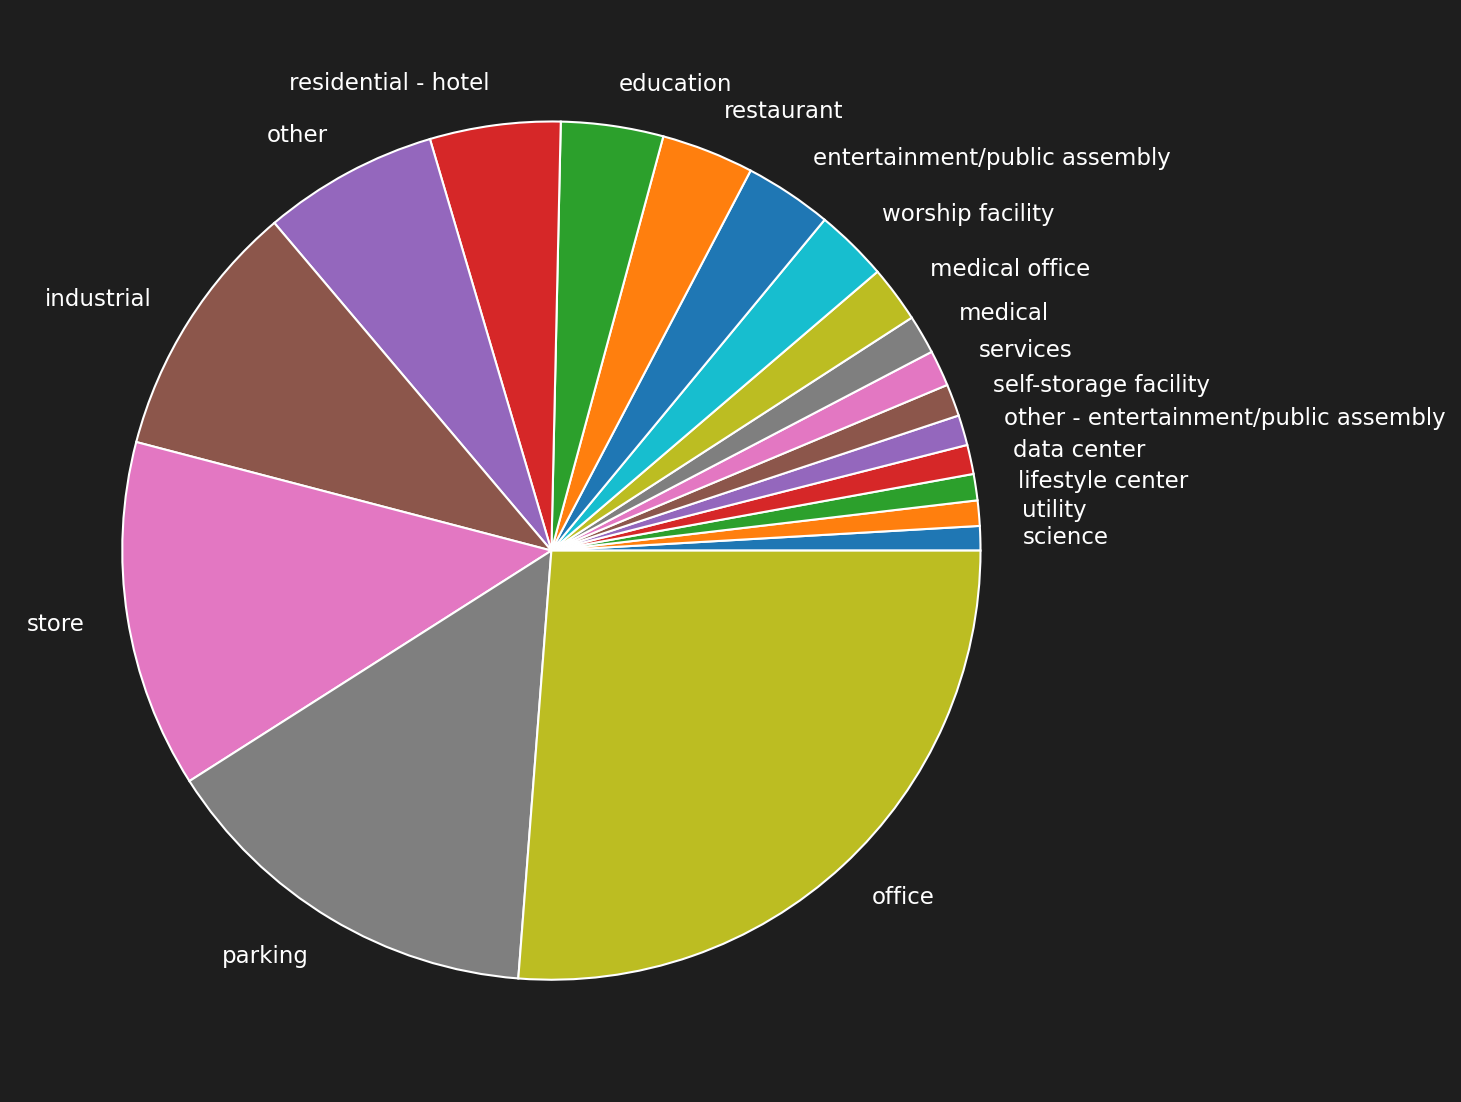

In [46]:
fig, ax = plt.subplots( figsize=(25*cm,25*cm) )
value_counts.plot( kind='pie', ax=ax )
fig.tight_layout()

## Year-built -> categories ?
à priori pas de relation directe évidente -> on peut séparer en plusieurs groupes

min: 1900 max: 2015
[1900 1920 1940 1960 1980 2000]


,YearBuilt,YearBuiltCateg
1302,1915,1
1215,1955,4
2381,1921,2
394,1986,6
537,1928,2
1568,1965,5
1272,1926,2
480,1953,4
952,1982,6
2607,1946,4


,YearBuilt,YearBuiltCateg
0,1927,2
1,1996,6
2,1969,5
3,1926,2
4,1980,6
5,1999,6
6,1926,2
7,1926,2
8,1904,1
10,1969,5


breaks begin at: [1932 1942]
breaks end at: [1935 1944]


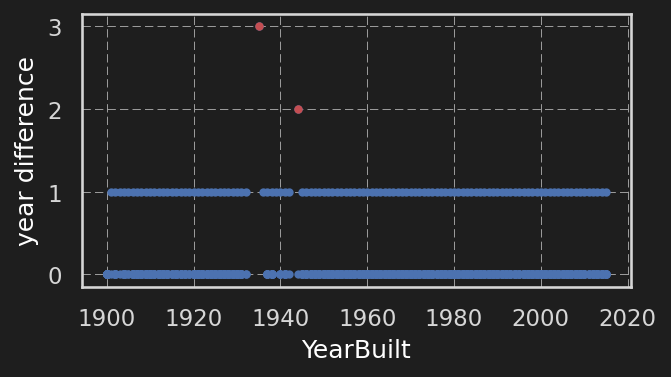

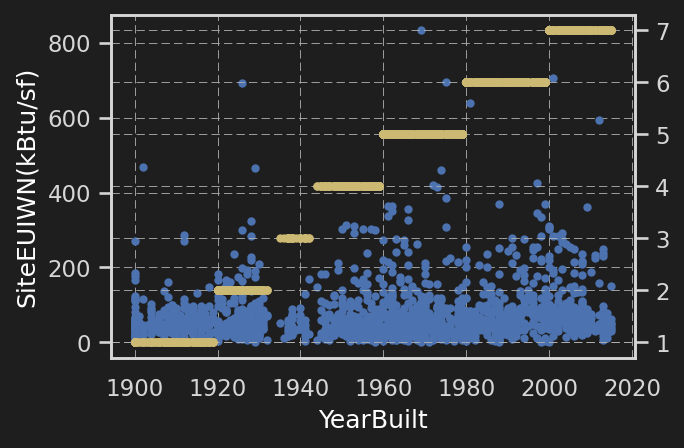

In [47]:
X, Y = 'YearBuilt', 'SiteEUIWN(kBtu/sf)'

print('min:', df[X].min(), 'max:', df[X].max() )
print( np.arange( 1900, 2020, 20 ) )

bins_yearbuilt = [1900, 1920, 1934, 1943, 1960, 1980, 2000, 2020]
df['YearBuiltCateg'] = np.digitize( df[X], bins_yearbuilt )
display( df[[X, 'YearBuiltCateg']].sample(10) )
display( df[[X, 'YearBuiltCateg']].head(10) )

x = df[X].values.copy()
x.sort()
diff_x = x[1:]-x[:-1]
b_break = diff_x > 1
print( 'breaks begin at:', x[:-1][ b_break ])
print( 'breaks end at:', x[1:][ b_break ])

fig, ax = plt.subplots( figsize=(12*cm,6*cm) )
ax.plot( x[1:], diff_x, 'bo', markersize=3 )
ax.plot( x[1:][ b_break ], diff_x[ b_break ], 'ro', markersize=3 )
ax.set_xlabel(X)
ax.set_ylabel( 'year difference' )

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( df[X], df[Y], 'bo', markersize=3 )
ax_twinx = ax.twinx()
ax_twinx.plot( df[X], df['YearBuiltCateg'], 'yo', markersize=3 )


ax.set_xlabel( X )
ax.set_ylabel( Y )
fig.tight_layout()

***
# 4. Target

## 4.1 Vérifications et gestion des données

Présence de valeurs incohérentes (0 != sum autres variables) pour `SiteEUIWN(kBtu/sf)`

On regarde les dates des relevés

In [48]:
display( df['DataYear'].value_counts() )

2016    1549
Name: DataYear, dtype: int64

Toutes les mesures ont été faites la même année

estmated coefficient: 1.006


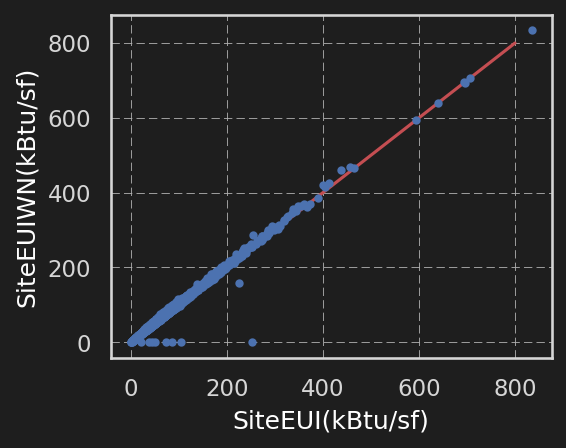

In [49]:
X, Y = 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)'

x,y = df[[X,Y]].dropna().values.T
lr = linear_model.LinearRegression()
lr.fit( x.reshape(-1,1), y )
print( f'estmated coefficient: {lr.coef_[0]:.3f}' )

fig, ax = plt.subplots( figsize=(10*cm,8*cm))
ax.plot( x, y, 'bo', markersize=3, zorder=2 )
ax.plot( [0,800], [0,800], 'r', zorder=1 )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

Certaines valeurs sont à 0. -> on prend la valeur non WN puisque les valeurs sont proches (pour ce dataset)

In [50]:
sr_loc = (df[Y] == 0.) | (df[Y].isna())
print('nombre de 0 | NaN:', sr_loc.sum())
display( df.loc[sr_loc,:] )
df.loc[sr_loc, Y] = df.loc[sr_loc, X]

nombre de 0 | NaN: 9


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,AgeOfBuilding(s),YearBuiltCateg
220,343,2016,nonresidential,large office,norton building,801 2nd ave suite 1300,seattle,wa,98104.0,0939000355,7,downtown,47.60370,-122.33447,1958,1.0,17,378525,84600,293925,"office, parking",office,236827.0,parking,83311.0,restaurant,14679.0,NaN,69.0,105.199997,0.0,240.899994,0.0,2.490613e+07,0.0,10921066.00,4.098788e+06,13985064.0,0.000000,0.0,False,compliant,0,940.47,2.48,58,4
247,372,2016,nonresidential,large office,metropolitan park east,1730 minor avenue,seattle,wa,98101.0,0660002410,7,downtown,47.61695,-122.32965,1988,1.0,20,497513,118744,378769,"office, parking",office,367623.0,parking,114510.0,NaN,NaN,2015201320122010,65.0,73.000000,0.0,227.899994,0.0,2.682322e+07,0.0,0.00,7.796691e+06,26602310.0,2209.050049,220905.0,False,compliant,0,197.19,0.40,28,6
284,414,2016,nonresidential,large office,onni 1411 fourth development lp,1411 4th ave,seattle,wa,98101.0,1975700345,7,downtown,47.60923,-122.33625,1929,1.0,15,151039,0,151039,office,office,125473.0,NaN,NaN,NaN,NaN,NaN,84.0,43.400002,0.0,92.300003,0.0,5.446624e+06,0.0,2850077.75,7.610041e+05,2596546.0,0.000000,0.0,False,compliant,0,238.09,1.58,87,2
350,493,2016,nonresidential,small- and mid-sized office,200 first ave w,200 1st ave w,seattle,wa,98119.0,1989201020,7,magnolia / queen anne,47.62014,-122.35768,1971,1.0,5,88000,21600,66400,"office, parking",office,69691.0,parking,17487.0,NaN,NaN,NaN,75.0,50.000000,0.0,157.000000,0.0,3.484916e+06,0.0,0.00,1.021370e+06,3484915.0,0.000000,0.0,False,compliant,0,24.29,0.28,45,5
563,757,2016,nonresidential,large office,market place i & ii-2003 western avenue,2003 western avenue,seattle,wa,98121.0,1977200280,7,downtown,47.61051,-122.34439,1979,1.0,7,131143,87160,43983,"office, retail store",office,120248.0,store,10853.0,NaN,NaN,NaN,93.0,39.500000,NaN,128.000000,0.0,5.177270e+06,NaN,0.00,1.427645e+06,4871126.0,14160.409180,1416041.0,False,compliant,0,109.16,0.83,37,5
882,20130,2016,nonresidential,worship facility,green lake united methodist church,6415 1st ave ne,seattle,wa,98115.0,1257200735,6,northwest,47.67572,-122.32850,1910,1.0,2,23931,0,23931,worship facility,worship facility,23931.0,NaN,NaN,NaN,NaN,NaN,88.0,20.700001,0.0,36.400002,0.0,4.964773e+05,0.0,0.00,4.896690e+04,167075.0,3294.021729,329402.0,False,compliant,0,18.66,0.78,106,1
953,20324,2016,nonresidential,worship facility,temple beth am,2632 ne 80th st.,seattle,wa,98115.0,1513800009,4,northeast,47.68752,-122.29852,2000,1.0,2,31386,0,31386,worship facility,worship facility,30000.0,NaN,NaN,NaN,NaN,NaN,52.0,37.599998,0.0,89.000000,0.0,1.128179e+06,0.0,0.00,2.082293e+05,710478.0,4177.007813,417701.0,False,compliant,0,27.14,0.86,16,7
3275,49968,2016,nonresidential,university,aerospace,3795 e stevens way ne,seattle,wa,98195.0,1625049001,4,northeast,47.65395,-122.30584,1969,1.0,4,58779,0,58779,college/university,education,58779.0,NaN,NaN,NaN,NaN,NaN,NaN,85.099998,0.0,221.000000,0.0,5.000717e+06,0.0,0.00,1.090040e+06,3719217.0,0.000000,0.0,False,compliant,0,25.93,0.44,47,5
3277,49972,2016,nonresidential,university,computer science and electrical engineering,3785 e stevens way ne,seattle,wa,98195.0,1625049001,4,northeast,47.65356,-122.30613,1998,1.0,6,203030,0,203030,

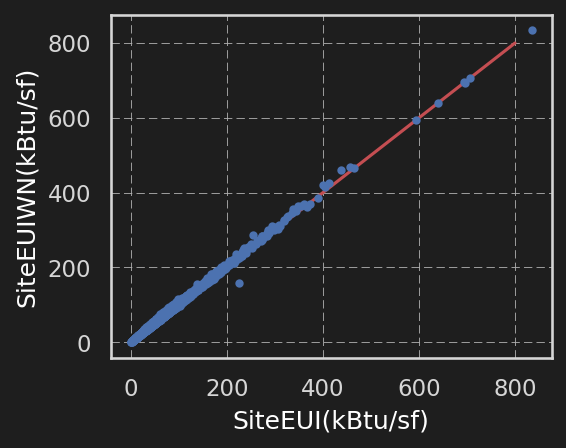

In [51]:
x,y = df[[X,Y]].dropna().values.T

fig, ax = plt.subplots( figsize=(10*cm,8*cm))
ax.plot( x, y, 'bo', markersize=3, zorder=2 )
ax.plot( [0,800], [0,800], 'r', zorder=1 )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

- `SiteEUI(kBtu/sf)` est basée sur les factures
- `SourceEUI(kbtu/sf)` : "the annual energy used to operate the property, including losses from generation, transmission, & distribution."

estmated coefficient: 2.377


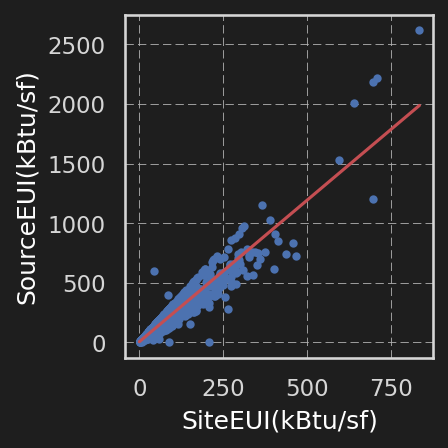

In [52]:
X, Y = 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)'

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo', markersize=3 )

x = np.array([0, df[X].max()]).reshape(2,1)
ax.plot( x, lr.predict(x), 'r' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

Vérification de conversion kWh -> Btu : OK

estmated coefficient: 3.412, theoretical: 3.412142


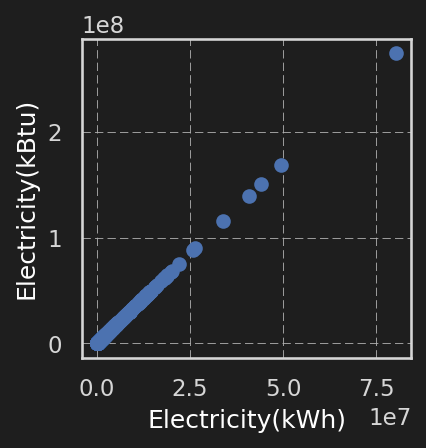

In [53]:
X, Y = 'Electricity(kWh)', 'Electricity(kBtu)'
coef = 3.412142 # in [Btu] / [Wh]

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}, theoretical: {coef:}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

vars_to_delete.append( X )

Vérification de conversion therms -> Btu : OK

estmated coefficient: 100.000, theoretical: 100.0


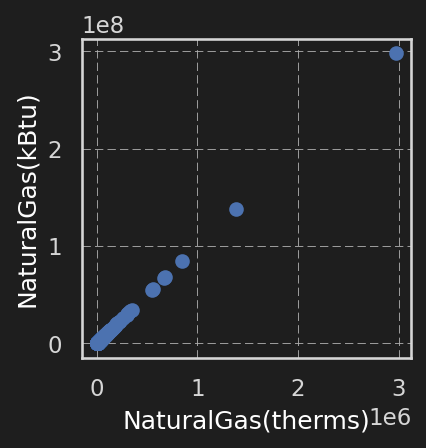

In [54]:
X, Y = 'NaturalGas(therms)', 'NaturalGas(kBtu)'
coef = 1e2 # in [kBtu]/[therms]

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}, theoretical: {coef:}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

vars_to_delete.append( X )

Vérification de la somme des ressources utilisées.

`SiteEnergyUse(kBtu)` :The annual amount of energy consumed by the property from all sources of energy.

Certaines valeurs diffèrent mais la proportion semble assez faible

DataFrame shape: (1549, 47)
24 values differs more than 30%


,count,mean,std,min,25%,50%,75%,max
SiteEnergyUse(kBtu),1549.0,8.232612e+06,2.212090e+07,16808.90039,1234095.5,2701872.0,7273155.5,448385312.0
sum ressources,1549.0,8.182119e+06,2.208832e+07,-115417.00000,1232823.0,2669564.0,7258758.0,448385283.0


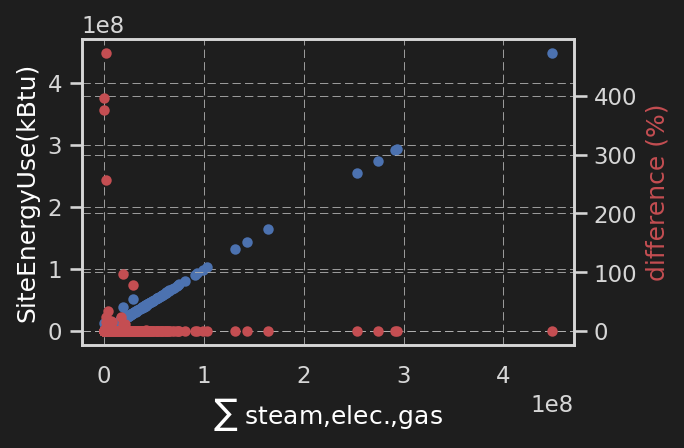

In [55]:
X, Y = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], 'SiteEnergyUse(kBtu)'


X_values = df[X].sum(1)
diff = X_values - df[Y]
diff_ratio = diff.abs() / X_values.abs() * 100

print('DataFrame shape:', df.shape)
print('{:} values differs more than 30%'.format( (diff_ratio > 0.3).sum() ))

display( pd.DataFrame( {Y:df[Y], 'sum ressources':X_values} ).describe().T )

fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( X_values, df[Y], 'bo', markersize=4 )
ax.set_xlabel(r'$\sum$ steam,elec.,gas')
ax.set_ylabel(Y)

ax_twinx = ax.twinx()
ax_twinx.plot( X_values, diff_ratio, 'ro', markersize=4 )
ax_twinx.set_ylabel('difference (%)', color='r')

fig.tight_layout()

On regarde à quoi correspondent les surfaces

Il y a clairement des incohérences entre les `LargestPropertyUseTypeGFA` et (`PropertyGFATotal`, `PropertyGFABuilding(s)`, `PropertyGFAParking`, `NumberofFloors`)

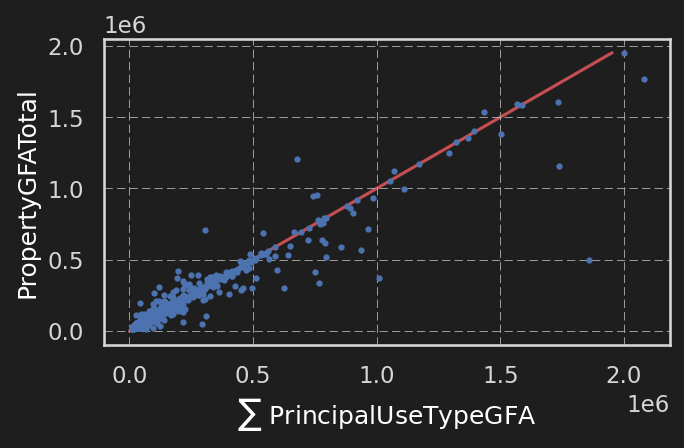

In [56]:
x = df[['LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA']].fillna(0.).sum(1)


Y = 'PropertyGFATotal'
y = df[Y]


fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( x, y, 'bo', markersize=2 )
ax.plot( [0, y.max()], [0, y.max()], 'r', zorder=0 )

ax.set_xlabel(r'$\sum$ PrincipalUseTypeGFA')
ax.set_ylabel(Y)

fig.tight_layout()

['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'AgeOfBuilding(s)', 'YearBuiltCateg']


,count,mean,std,min,25%,50%,75%,max
SiteEUIWN(kBtu/sf),1549.0,77.874887,76.744916,0.7,37.000000,56.200001,87.900002,834.400024
re-calculated,1548.0,72.981709,77.727568,0.0,33.243853,50.895253,82.420727,953.072956


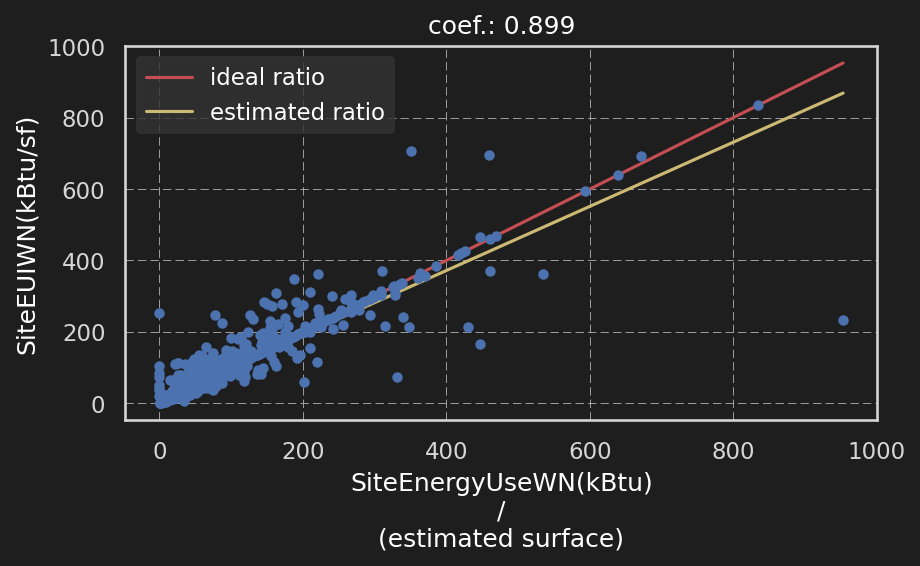

In [57]:
print( df.keys().tolist())
X, Y = 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)'

fig, ax = plt.subplots( figsize=(16*cm,10*cm))
X_values = df[X] / y
diff = X_values - df[Y]

sr_drop = (X_values.isna()) | ( df[Y].isna())

lr = linear_model.LinearRegression()
lr.fit( X_values.loc[~sr_drop].values.reshape(-1,1), df.loc[~sr_drop, Y] )
# print( f'\nEstmated coefficient: {lr.coef_[0]:.3f}, ideal: {1:}' )

display( pd.DataFrame( {Y:df[Y], 're-calculated':X_values} ).describe().T )

ymax = df[Y].max()
xmax = X_values.max()
ax.set_title( f'coef.: {lr.coef_[0]:.3f}' )
ax.plot( [0,xmax], [0,xmax], 'r', label='ideal ratio' )
ax.plot( [0,xmax], lr.predict( np.array([0,xmax]).reshape(-1,1) ), 'y', label='estimated ratio' )
ax.plot( X_values, df[Y], 'bo', markersize=4 )
ax.set_xlabel( X + '\n/\n(estimated surface)')
ax.set_ylabel(Y)
ax.legend()

# ax_twinx = ax.twinx()
# ax_twinx.plot( X_values, np.abs(diff) / X_values * 100, 'ro', markersize=4 )
# ax_twinx.set_ylabel('difference (%)', color='r')

fig.tight_layout()

On prend la valeur "Weather Normalize" et normalisée par la surface comme cible : "SiteEUIWN(kBtu/sf)".

In [58]:
targets = ['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']

In [59]:
df[targets].info()

for target in targets:
    sr_0 = (df[target] == 0) | (df[target].isna())
    print( f'\nnumber of elements {target} == 0 | isna:', (sr_0).sum())
# display( df.loc[sr_0,:])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549 entries, 0 to 3375
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SiteEUIWN(kBtu/sf)     1549 non-null   float64
 1   GHGEmissionsIntensity  1549 non-null   float64
dtypes: float64(2)
memory usage: 36.3 KB

number of elements SiteEUIWN(kBtu/sf) == 0 | isna: 0

number of elements GHGEmissionsIntensity == 0 | isna: 3


count    1549.000000
mean       77.874887
std        76.744916
min         0.700000
25%        37.000000
50%        56.200001
75%        87.900002
max       834.400024
Name: SiteEUIWN(kBtu/sf), dtype: float64

count    1549.000000
mean        1.660478
std         2.409203
min        -0.020000
25%         0.350000
50%         0.880000
75%         1.960000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64

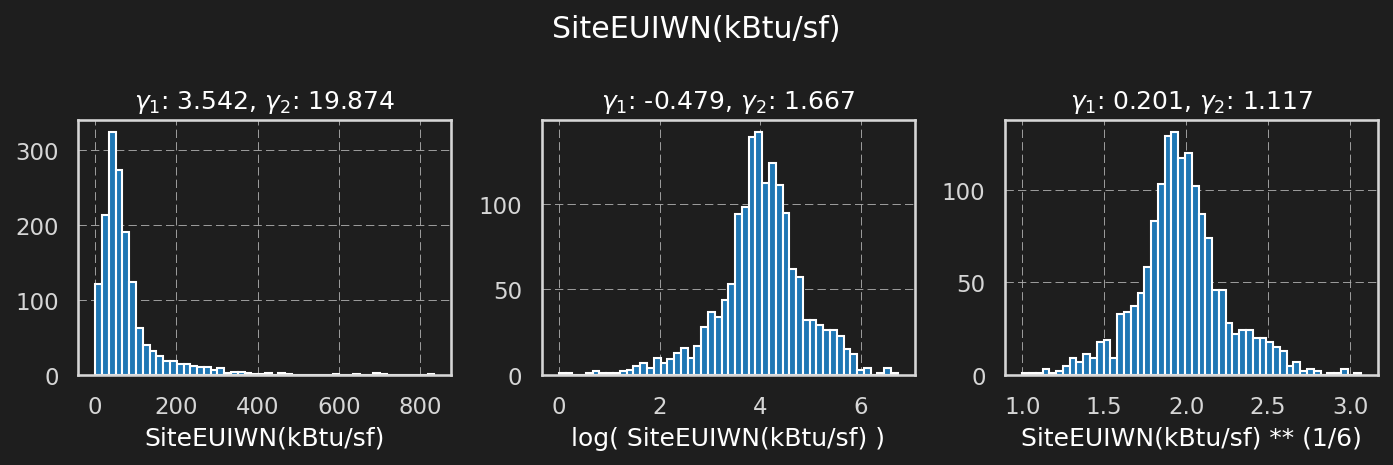

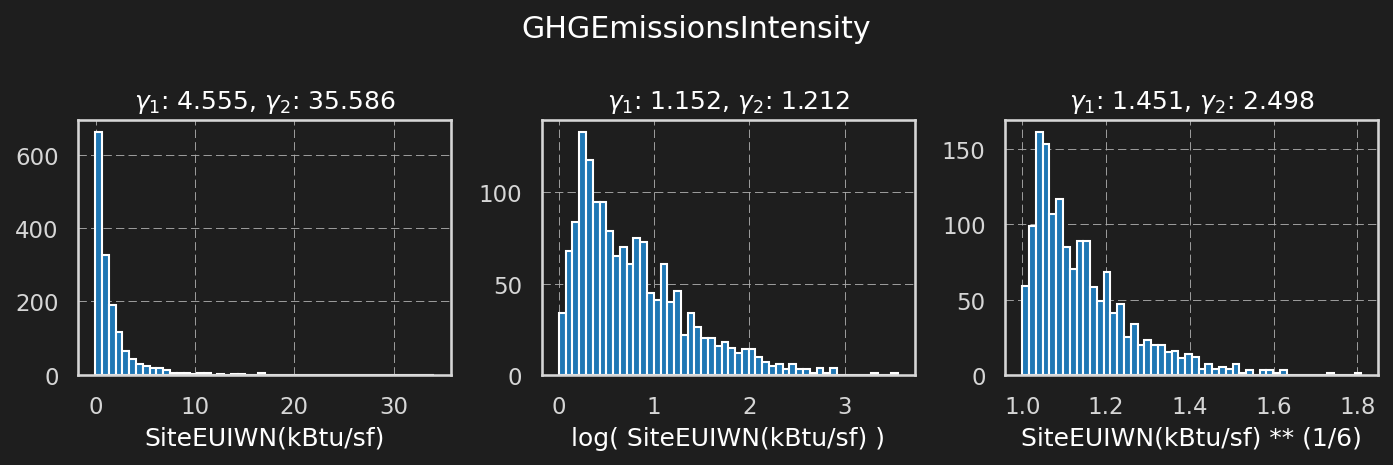

In [60]:
power_inv_targets = [6, 6]
for target, power_inv in zip( targets, power_inv_targets ):
    y = df[target].dropna()

    display( y.describe() )

    y_pow = (y+1.-y.min())**(1/power_inv)
    # print( y_log.min(), y_log.max(), np.isnan(y_log).sum())

    # print( ( y + (1-y.min()) ).min() )
    y_log = np.log( y + (1-y.min() ) )


    fig, axs = plt.subplots( ncols=3, figsize=(24*cm,8*cm) )
    n, bins, _ = axs[0].hist( y, bins=50 )
    n, bins, _ = axs[1].hist( y_log, bins=50 )
    n, bins, _ = axs[2].hist( y_pow, bins=50 )
    axs[0].set_xlabel(Y )
    axs[1].set_xlabel( f'log( {Y} )' )
    axs[2].set_xlabel( f'{Y} ** (1/{power_inv})' )

    axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
    axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_log), st.kurtosis(y_log) ) )
    axs[2].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_pow), st.kurtosis(y_pow) ) )

    fig.suptitle( target )
    fig.tight_layout()

    log_target_bins_center = (bins[:-1] + bins[1:]) * 0.5 

## 4.2 Scatter plots

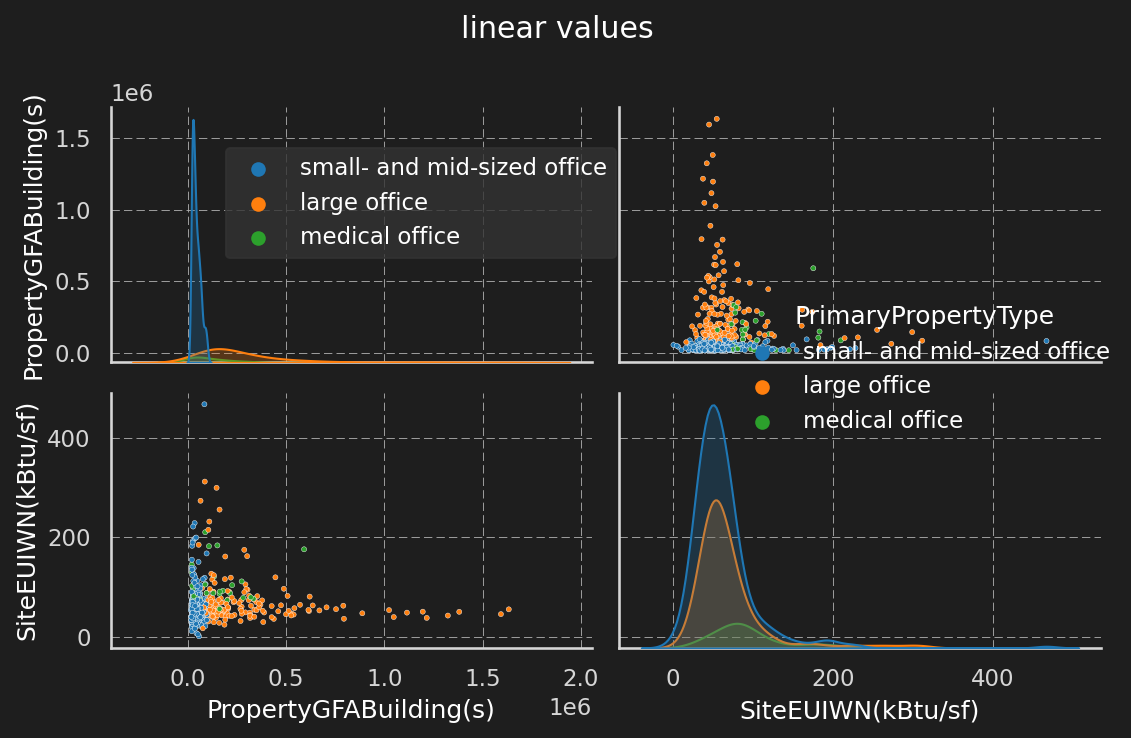

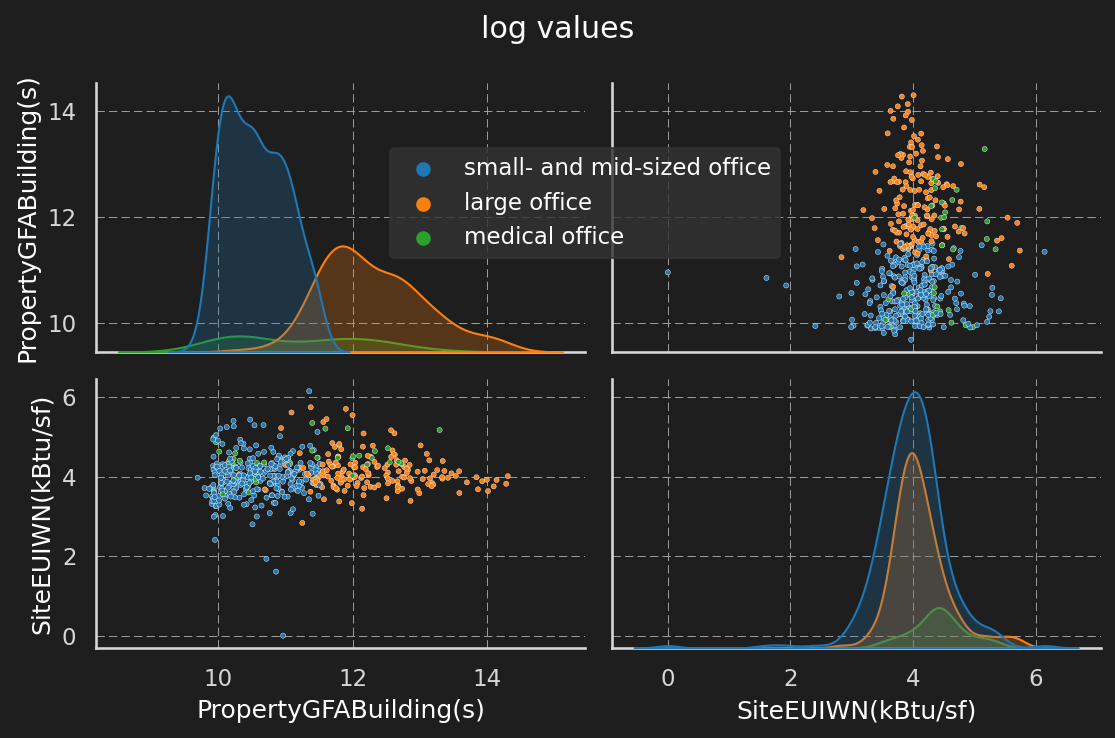

In [61]:

Xs = ['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']
hues = ['PrimaryPropertyType', 'LargestPropertyUseType']

# df[target]

Y = targets[0]

sr_loc = (df[Y] != 0)
for X in Xs:
    sr_loc = sr_loc & (df[X]!=0)
tmp = df.loc[sr_loc, Xs + hues + [Y, 'Outlier']]
# tmp = df[[X,target, 'Outlier', hue]]

if True:
    # tmp[ Xs[1] ] /= tmp[ Xs[0] ]
    # sr_loc = tmp[Xs[1]] > 0.7
    sr_loc = tmp[hues[0]].str.contains('office')
    tmp = tmp.loc[sr_loc,:]


for X,hue in zip( Xs, hues ):
    g = sns.pairplot( data=tmp, vars=[X,Y], hue=hue,
        plot_kws={'s':6} )
    
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=[0.2,0.65], ncol=1)

    g.fig.suptitle('linear values')
    g.fig.tight_layout()
    

    tmp[X] = np.log( tmp[X] )
    tmp[Y] = np.log( tmp[Y] )
    g = sns.pairplot( data=tmp, vars=[X,Y], hue=hue,
        plot_kws={'s':6} )
    # g.legend(bbox_to_anchor= (1.03, 1) )
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=[0.35,0.65], ncol=1)
    g.legend.remove()
    g.fig.suptitle('log values')
    g.fig.tight_layout()
    
    break


In [62]:
def ANOVA( df, hue, Y, transform=None ):
    groups = df[[Y,hue]].dropna().groupby(hue)[Y]
    index = pd.MultiIndex.from_tuples( [('shape','skew'), ('shape','kurtosis'),('shapiro','statistic'), ('shapiro','p-value')] )
    df_shape = pd.DataFrame( index = index)
    names = [name for name,yi in groups]
    for name, yi in groups:
        if not transform is None:
            yi = transform( yi )
        # print('\nname:', name)
        # print( st.skew(yi) )
        # print( st.kurtosis(yi) )
        # print( st.shapiro(yi) )
        # sr = pd.Series( [  ] ).astype(float)
        shapiro = st.shapiro(yi)
        df_shape[name] = [st.skew(yi), st.kurtosis(yi), shapiro.statistic, shapiro.pvalue]
    
    print('Shapiro null hypothesis: data has a normal distribution')
    display(df_shape.round(3))

    levene = pg.homoscedasticity( df.dropna(), dv=Y, group=hue )
    print( 'small p-value suggests that the populations do not have equal variances' )
    display( levene )

    # tpl = tuple( [df.query( f'{hue} == "{name}"')[Y].dropna() for name in names ] )
    # print( st.levene( *tpl ) )
    

    print('small p-value suggests that there is a statistically significant difference between the means of groups')
    display( pg.pairwise_tukey( dv=Y, between=hue, data=df.dropna() ) )

    # for i, (name,yi) in enumerate(groups):
    #     print('\n\n| {:} |\n\n'.format( '-'*20 ))
    #     if i+1 == len(names):
    #         break
    #     print(f'name: {name}')
    #     for j, (name_2,yi2) in enumerate(groups):
    #         if j <= i:
    #             continue
    #         print( f'\n{name} - {name_2}:' )
    #         stat, p = st.levene(yi, yi2)
    #         print( f'levene stat: {stat:.3f}, p-value: {p:.3f}' )
    #         print('std: {:.3f} - {:.3f}'.format( yi.std(), yi2.std() ) )
print('linear')
ANOVA( tmp, 'PrimaryPropertyType', 'SiteEUIWN(kBtu/sf)' )
# print('log')
# ANOVA( tmp, 'PrimaryPropertyType', 'SiteEUIWN(kBtu/sf)', lambda y:np.log( y + (1-y.min())) )

linear
Shapiro null hypothesis: data has a normal distribution


large office  medical office  small- and mid-sized office
shape   skew              1.161           0.079                       -1.185
        kurtosis          2.478          -0.051                        9.460
shapiro statistic         0.913           0.966                        0.901
        p-value           0.000           0.271                        0.000

small p-value suggests that the populations do not have equal variances


,W,pval,equal_var
levene,2.154459,0.117048,True


small p-value suggests that there is a statistically significant difference between the means of groups


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,large office,medical office,4.117323,4.420021,-0.302698,0.092725,-3.264467,0.003355,-0.668858
1,large office,small- and mid-sized office,4.117323,3.979876,0.137447,0.050349,2.729898,0.017986,0.259009
2,medical office,small- and mid-sized office,4.420021,3.979876,0.440145,0.089188,4.935007,0.000003,0.791421


Les "office" semblent être des "small" offices

In [63]:
mask = "PrimaryPropertyType"
df.loc[ df[mask] == 'office', mask] = 'small- and mid-sized office'

***
# Features des modèles

## Suppression des variables non utilisées

In [64]:
df_annexe = df[['PropertyName']].copy() # DataFrame des variables à garder sous le coude
df.drop( columns= [col for i, col in enumerate(vars_to_delete) if (col in df.columns) and (not col in vars_to_delete[:i])], inplace=True )
vars_to_delete = []
print('DataFrame.shape', df.shape)
df.columns

DataFrame.shape (1549, 32)


Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'DefaultData',
       'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'AgeOfBuilding(s)', 'YearBuiltCateg'],
      dtype='object')

Les variables 'BuildingType', 'PrimaryPropertyType' ne seront pas utilisées, car redondant par rapport aux `LargestPropertyUseTypes` 

In [65]:
df.drop( columns=['BuildingType', 'PrimaryPropertyType'] , inplace=True )
print('DataFrame.shape', df.shape)
df.columns

DataFrame.shape (1549, 30)


Index(['Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'DefaultData',
       'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'AgeOfBuilding(s)', 'YearBuiltCateg'],
      dtype='object')

In [66]:
print('DataFrame shape:', df.shape )

mask = ['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
'SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)',
'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
df.drop( columns=mask, inplace=True )

mask = ['YearsENERGYSTARCertified',
    'YearBuiltCateg', 'DefaultData', 'ComplianceStatus']
df_annexe[mask] = df[mask].copy()
df.drop( columns=mask, inplace=True )

print('DataFrame shape:', df.shape )
print('DataFrame annexe shape:', df_annexe.shape )

DataFrame shape: (1549, 30)
DataFrame shape: (1549, 20)
DataFrame annexe shape: (1549, 5)


In [67]:
df.columns

Index(['Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Outlier',
       'GHGEmissionsIntensity', 'AgeOfBuilding(s)'],
      dtype='object')

## Corrélation des variables
Une (force) corrélation est à noter entre les variables:
- PropertyTotalGFA, PropertyGFABuilding(s) LargestPropertyUseTypeGFA et SecondLargestPropertyUseTypeGFA 
- TotalGHGEmissionIntensity et SiteEUIWN(kBtu/sf)
- Electricity(kBtu) et les variables GFA

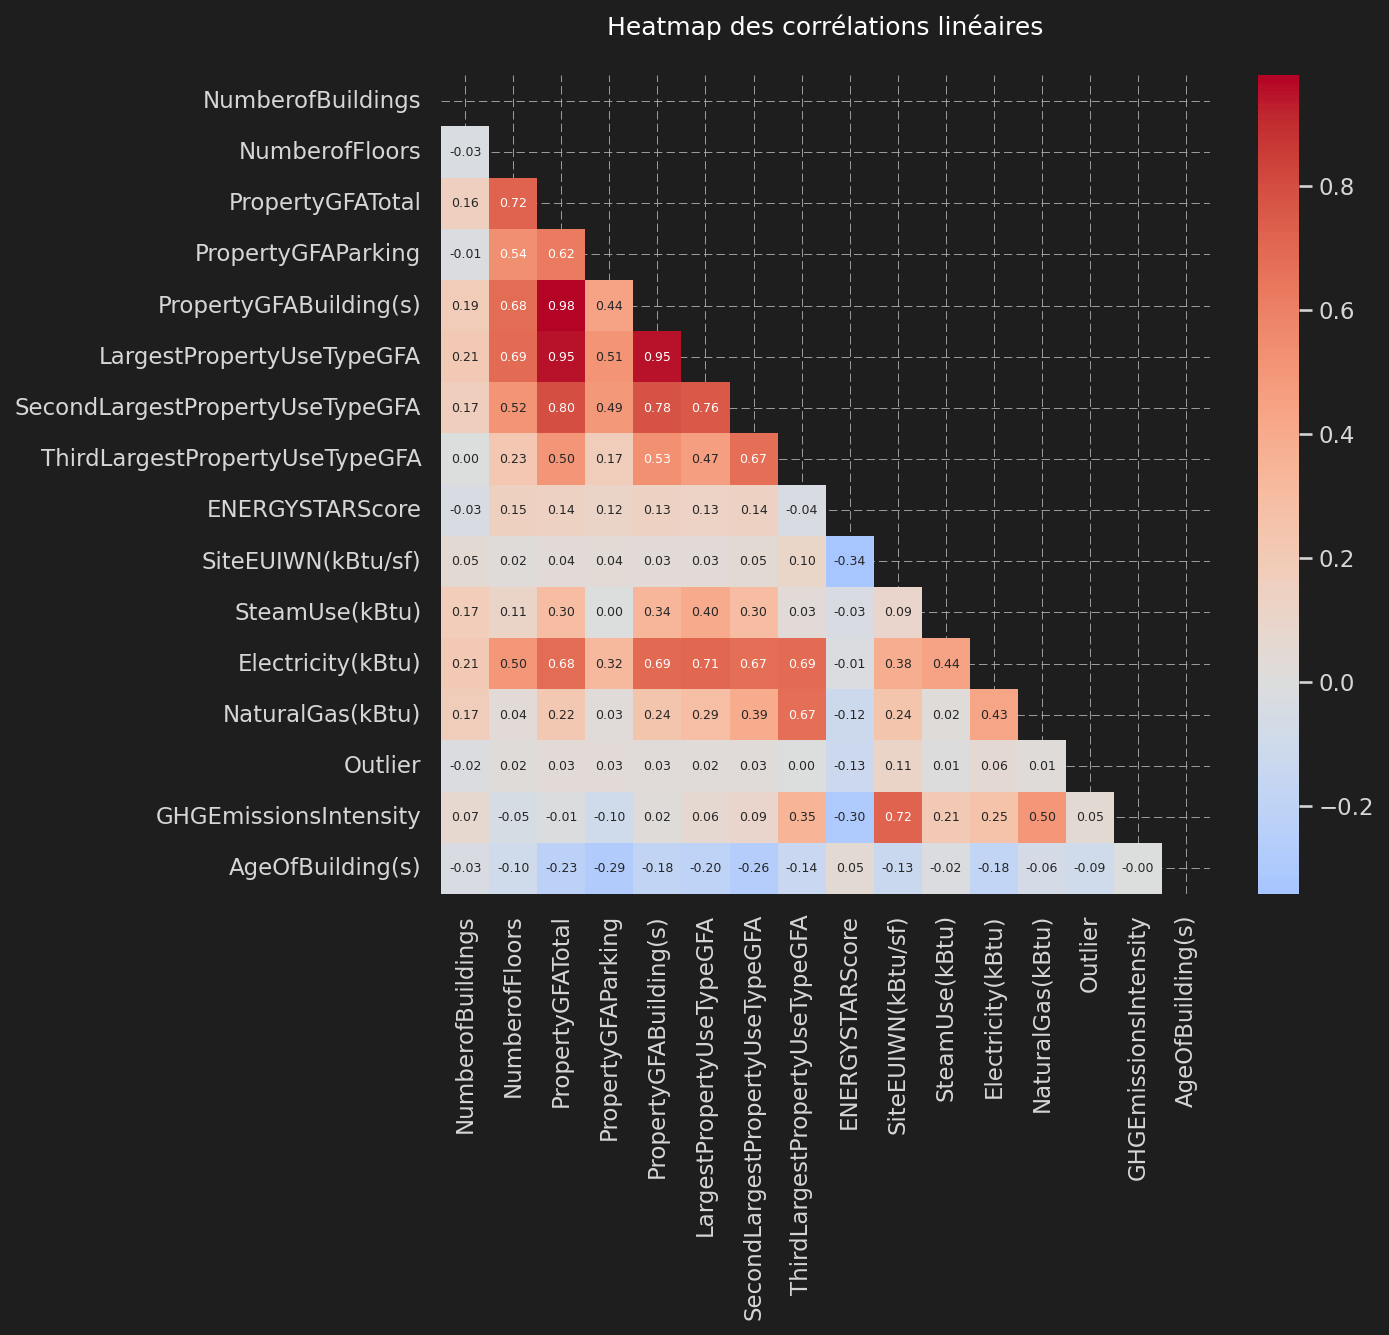

In [68]:
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(21*cm,18*cm))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':6}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [69]:
mask = ['ENERGYSTARScore']
df_annexe[mask] = df[mask].copy()
df.drop( columns=mask, inplace=True )

## PCA

In [70]:
tmp = df.select_dtypes(include=[np.number])
features = [col for col in tmp.columns if not col in vars_to_delete]
print(features)

['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'GHGEmissionsIntensity', 'AgeOfBuilding(s)']


In [71]:
X = df[features].dropna()
scaler_pca = preprocessing.StandardScaler()
X_scaled = scaler_pca.fit_transform(X) # fit and transform
idx = ["mean", "std"]
display( pd.DataFrame(X_scaled).describe().round(2).loc[idx, :] )

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
mean,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [72]:
from sklearn.decomposition import PCA
n_components = X_scaled.shape[1]
pca = PCA(n_components=n_components)

# entrainement
pca.fit(X_scaled)

PCA(n_components=15)

scree: [39.19 16.37  8.64  7.46  6.8   6.35  4.59  3.51  2.54  1.7   1.51  0.84
  0.32  0.16  0.  ]
sum scree: 100.0


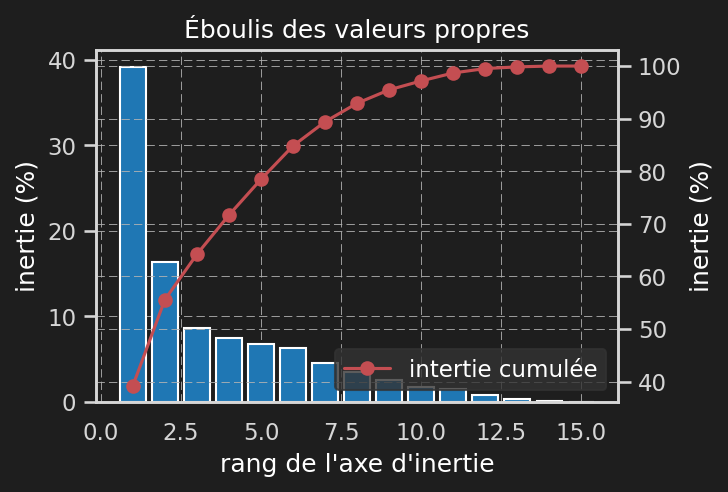

In [73]:
x_list = range(1, n_components+1)
scree = (pca.explained_variance_ratio_*100)
print('scree:', scree.round(2))
print('sum scree:', scree.sum().round(2))
fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.bar( x_list, scree )
ax.set_xlabel("rang de l'axe d'inertie")
ax.set_ylabel("inertie (%)")
ax.set_title('Éboulis des valeurs propres')

ax = ax.twinx()
ax.set_ylabel("inertie (%)")

ax.plot( x_list, scree.cumsum(), c='r', marker='o', label='intertie cumulée')
ax.legend()

fig.tight_layout(pad=0.2)
# tools.savefig( fig, 'Figures/PCA/ebouli.pdf')

On observe les premiers axes d'inertie

,PropertyGFATotal,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),SecondLargestPropertyUseTypeGFA,Electricity(kBtu),NumberofFloors,ThirdLargestPropertyUseTypeGFA,PropertyGFAParking,NaturalGas(kBtu),SteamUse(kBtu),GHGEmissionsIntensity,SiteEUIWN(kBtu/sf),NumberofBuildings,Outlier,AgeOfBuilding(s)
F1,0.389151,0.388854,0.378374,0.36732,0.360399,0.30748,0.274096,0.25123,0.161104,0.066724,0.047503,0.029465,0.012862,0.006479,-0.151157


,GHGEmissionsIntensity,NaturalGas(kBtu),SiteEUIWN(kBtu/sf),ThirdLargestPropertyUseTypeGFA,Electricity(kBtu),Outlier,SecondLargestPropertyUseTypeGFA,SteamUse(kBtu),NumberofBuildings,AgeOfBuilding(s),LargestPropertyUseTypeGFA,PropertyGFABuilding(s),PropertyGFATotal,PropertyGFAParking,NumberofFloors
F2,0.558915,0.48217,0.405007,0.293566,0.184525,0.078593,0.076351,0.017366,0.004686,-0.009615,-0.137803,-0.149506,-0.171747,-0.175254,-0.238515


,SiteEUIWN(kBtu/sf),Outlier,PropertyGFAParking,NumberofFloors,SteamUse(kBtu),Electricity(kBtu),GHGEmissionsIntensity,PropertyGFATotal,LargestPropertyUseTypeGFA,NumberofBuildings,PropertyGFABuilding(s),SecondLargestPropertyUseTypeGFA,NaturalGas(kBtu),ThirdLargestPropertyUseTypeGFA,AgeOfBuilding(s)
F3,0.537228,0.481697,0.305788,0.056752,0.044901,0.037768,0.036208,0.011312,-0.027909,-0.045385,-0.070073,-0.101427,-0.287908,-0.293291,-0.436805


,SteamUse(kBtu),AgeOfBuilding(s),NumberofFloors,GHGEmissionsIntensity,SiteEUIWN(kBtu/sf),LargestPropertyUseTypeGFA,PropertyGFABuilding(s),NumberofBuildings,PropertyGFATotal,Electricity(kBtu),Outlier,SecondLargestPropertyUseTypeGFA,NaturalGas(kBtu),PropertyGFAParking,ThirdLargestPropertyUseTypeGFA
F4,0.82816,0.362041,0.246817,0.187543,0.121117,0.061483,0.043735,0.015714,0.007513,0.003919,-0.019977,-0.115372,-0.127842,-0.129277,-0.139784


,NumberofBuildings,Outlier,AgeOfBuilding(s),Electricity(kBtu),PropertyGFABuilding(s),ThirdLargestPropertyUseTypeGFA,LargestPropertyUseTypeGFA,PropertyGFATotal,SecondLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),NaturalGas(kBtu),SteamUse(kBtu),NumberofFloors,GHGEmissionsIntensity,PropertyGFAParking
F5,0.922679,0.28968,0.131531,0.125522,0.035752,0.013402,0.005932,0.004525,-0.007154,-0.00786,-0.029821,-0.051283,-0.052018,-0.105755,-0.112509


,Outlier,AgeOfBuilding(s),ThirdLargestPropertyUseTypeGFA,PropertyGFABuilding(s),Electricity(kBtu),NumberofFloors,LargestPropertyUseTypeGFA,NaturalGas(kBtu),PropertyGFATotal,SecondLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,SteamUse(kBtu),PropertyGFAParking,NumberofBuildings
F6,0.750841,0.424211,0.139608,0.083693,0.066075,0.039481,0.03318,0.030779,0.024017,0.004511,-0.123657,-0.133818,-0.134678,-0.206658,-0.356614


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity,AgeOfBuilding(s)
F1,0.01,0.31,0.39,0.25,0.38,0.39,0.37,0.27,0.03,0.07,0.36,0.16,0.01,0.05,-0.15
F2,0.00,-0.24,-0.17,-0.18,-0.15,-0.14,0.08,0.29,0.41,0.02,0.18,0.48,0.08,0.56,-0.01
F3,-0.05,0.06,0.01,0.31,-0.07,-0.03,-0.10,-0.29,0.54,0.04,0.04,-0.29,0.48,0.04,-0.44
F4,0.02,0.25,0.01,-0.13,0.04,0.06,-0.12,-0.14,0.12,0.83,0.00,-0.13,-0.02,0.19,0.36
F5,0.92,-0.05,0.00,-0.11,0.04,0.01,-0.01,0.01,-0.01,-0.05,0.13,-0.03,0.29,-0.11,0.13
F6,-0.36,0.04,0.02,-0.21,0.08,0.03,0.00,0.14,-0.12,-0.13,0.07,0.03,0.75,-0.13,0.42


<Axes: >

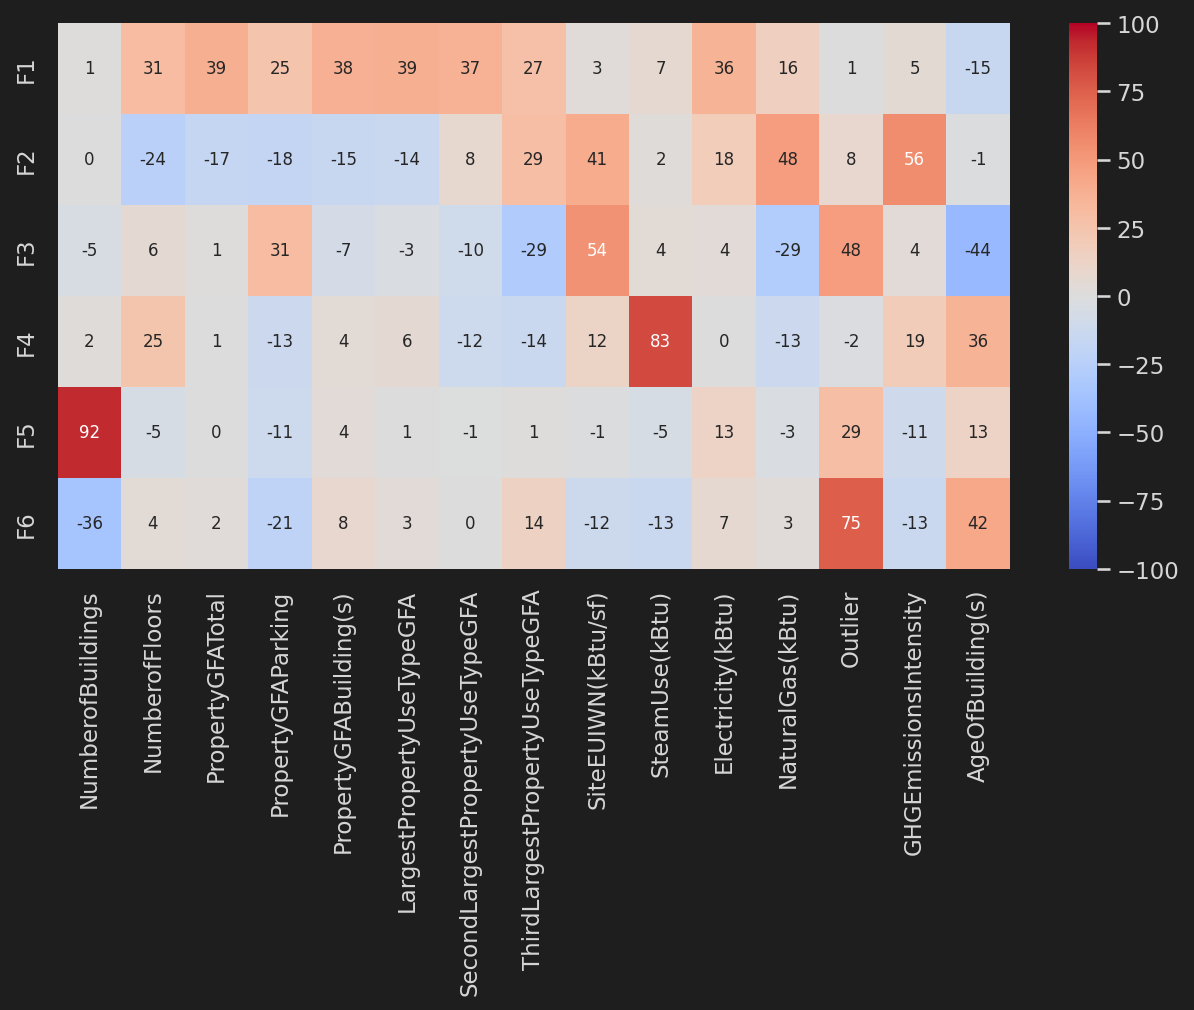

In [74]:
pcs = pd.DataFrame( pca.components_.transpose() )
pcs.index = features
columns = [f"F{i}" for i in x_list]
pcs.columns = columns

for i in range(6):
    key = f'F{i+1:}'
    display( pcs[[key]].sort_values( key, ascending=False ).T )

display( pcs.iloc[:,:6].round(2).T ) #.sort_values(by=indexes , ascending=False) )
fig, ax = plt.subplots(figsize=(26*cm, 12*cm))
sns.heatmap(pcs.iloc[:,:6].T*100, vmin=-100, vmax=100, annot=True, cmap="coolwarm", fmt="0.0f", annot_kws={"size": 8})
# fig.tight_layout( pad=0.2 )

## Calcul de ratios

On s'intrésse à des variables rapportée à la surface totale d'un site, donc on ramène les GFA à des ratios

In [75]:
df.sort_values( by='PropertyGFATotal' ).head()

,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity,AgeOfBuilding(s)
3363,north,1.0,1,11285,0,11285,utility,11285.0,NaN,NaN,NaN,NaN,62.599998,0.0,4.317954e+05,2.138700e+05,0,1.27,67
3361,central,1.0,1,11685,0,11685,utility,11685.0,NaN,NaN,NaN,NaN,82.900002,0.0,3.472887e+05,5.037650e+05,0,2.50,3
3362,ballard,1.0,1,11968,0,11968,utility,11968.0,NaN,NaN,NaN,NaN,71.800003,0.0,4.032431e+05,3.801800e+05,0,1.92,6
3365,ballard,1.0,1,12769,0,12769,entertainment/public assembly,10912.0,lifestyle center,1670.0,office,187.0,420.600006,0.0,1.205173e+06,3.912135e+06,0,16.93,44
3373,magnolia / queen anne,1.0,1,13157,0,13157,entertainment/public assembly,7583.0,lifestyle center,5574.0,entertainment/public assembly,0.0,460.100006,0.0,1.792159e+06,3.973739e+06,0,16.99,42


In [76]:
mask = 'PropertyGFATotal'
df_annexe[mask] = df[mask].copy()
df['PropertyGFABuilding(s)'] /= df[mask]
df['PropertyGFAParking'] /= df[mask]
df.rename( columns={'PropertyGFABuilding(s)':'%GFABuilding(s)', 'PropertyGFAParking':'%GFAParking'}, inplace=True )


mask2 = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
df[ mask2 ] = df[mask2].fillna(0.).values
df[ mask2 ] = df[ mask2 ] / df[ mask2 ].values.sum(1).reshape(-1,1)
df.rename( columns={ mask2[0]:'% use 1', mask2[1]:'% use 2', mask2[2]:'% use 3' }, inplace=True)
df.rename( columns={ mask2[0][:-3]:'Type use 1', mask2[1][:-3]:'Type use 2', mask2[2][:-3]:'Type use 3' }, inplace=True)
df.sample(5)

,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,%GFAParking,%GFABuilding(s),Type use 1,% use 1,Type use 2,% use 2,Type use 3,% use 3,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity,AgeOfBuilding(s)
1198,northwest,1.0,2,42793,0.385998,0.614002,office,0.614002,parking,0.385998,NaN,0.000000,71.199997,0.0,1772188.0,0.0,0,0.29,15
2519,ballard,1.0,2,21562,0.000000,1.000000,worship facility,0.981354,education,0.018646,NaN,0.000000,46.599998,0.0,189790.0,677016.0,0,1.73,60
36,greater duwamish,3.0,2,714095,0.000000,1.000000,industrial,0.639668,industrial,0.286604,office,0.073728,45.799999,0.0,44731153.0,0.0,0,0.44,55
625,magnolia / queen anne,1.0,5,141718,0.000000,1.000000,other - entertainment/public assembly,0.958550,restaurant,0.041450,NaN,0.000000,135.800003,0.0,14573159.0,4512014.0,0,2.41,17
2159,greater duwamish,1.0,1,48890,0.000000,1.000000,industrial,0.631819,office,0.368181,NaN,0.000000,47.400002,0.0,1082370.0,1017846.0,0,1.26,75


%GFABuilding(s) et %GFAParking sont corrélé ( l'un égale 1-l'autre)

In [77]:
print( 'entries without Parking:', (df['%GFAParking'] == 0).sum() )
print( 'entries with only buidlings:', (df['%GFABuilding(s)'] == 1).sum() )
print('DataFrame shape:', df.shape)

entries without Parking: 1222
entries with only buidlings: 1222
DataFrame shape: (1549, 19)


Le %GFAParking contient plus de valeurs égales à 0, on conserve donc le %GFABuilding(s)

In [78]:
df.drop( columns=['%GFAParking'], inplace=True )

Pour éviter les fuites de données, des ratios sont calculés pour les énergies

In [79]:
sources = ['NaturalGas(kBtu)', 'Electricity(kBtu)',
            'SteamUse(kBtu)']

In [80]:
df[sources] = df[sources].fillna(0.)
sr_0 = df[sources].sum(1) == 0.
print('Entrées avec des 0 :')
display( df.loc[sr_0,:] )

df.loc[sr_0,sources] = 1.

df[sources] = df[sources].values / df[sources].abs().values.sum(1).reshape(-1,1)
df.rename( columns={ var:'% {:}'.format( var.replace('(kBtu)', '') ) for var in sources }, inplace=True )
df.sample(5)

Entrées avec des 0 :


,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,%GFABuilding(s),Type use 1,% use 1,Type use 2,% use 2,Type use 3,% use 3,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity,AgeOfBuilding(s)
513,magnolia / queen anne,1.0,1,57176,1.0,store,0.658333,store,0.25,services,0.091667,214.100006,0.0,0.0,0.0,0,0.0,8


,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,%GFABuilding(s),Type use 1,% use 1,Type use 2,% use 2,Type use 3,% use 3,SiteEUIWN(kBtu/sf),% SteamUse,% Electricity,% NaturalGas,Outlier,GHGEmissionsIntensity,AgeOfBuilding(s)
1292,downtown,1.0,1,36314,1.000000,other,1.000000,NaN,0.000000,NaN,0.000000,51.900002,0.119913,0.650646,0.229441,0,1.22,54
219,downtown,1.0,22,384302,1.000000,office,0.986630,store,0.009307,restaurant,0.004063,29.600000,0.000000,1.000000,0.000000,0,0.18,87
379,ballard,1.0,5,322869,0.434898,parking,0.582552,store,0.417448,NaN,0.000000,134.800003,0.000000,0.626742,0.373258,0,1.28,8
1666,delridge,1.0,1,23260,1.000000,services,0.562124,office,0.437876,NaN,0.000000,77.500000,0.000000,0.446484,0.553516,0,2.25,53
1155,east,1.0,3,30971,1.000000,other,1.000000,NaN,0.000000,NaN,0.000000,96.000000,0.081819,0.465635,0.452547,0,3.06,96


In [81]:
df.sort_values( by='PropertyGFATotal' ).head()

,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,%GFABuilding(s),Type use 1,% use 1,Type use 2,% use 2,Type use 3,% use 3,SiteEUIWN(kBtu/sf),% SteamUse,% Electricity,% NaturalGas,Outlier,GHGEmissionsIntensity,AgeOfBuilding(s)
3363,north,1.0,1,11285,1.0,utility,1.000000,NaN,0.000000,NaN,0.000000,62.599998,0.0,0.668760,0.331240,0,1.27,67
3361,central,1.0,1,11685,1.0,utility,1.000000,NaN,0.000000,NaN,0.000000,82.900002,0.0,0.408069,0.591931,0,2.50,3
3362,ballard,1.0,1,11968,1.0,utility,1.000000,NaN,0.000000,NaN,0.000000,71.800003,0.0,0.514719,0.485281,0,1.92,6
3365,ballard,1.0,1,12769,1.0,entertainment/public assembly,0.854570,lifestyle center,0.130785,office,0.014645,420.600006,0.0,0.235509,0.764491,0,16.93,44
3373,magnolia / queen anne,1.0,1,13157,1.0,entertainment/public assembly,0.576347,lifestyle center,0.423653,entertainment/public assembly,0.000000,460.100006,0.0,0.310820,0.689180,0,16.99,42


## Scatter plots

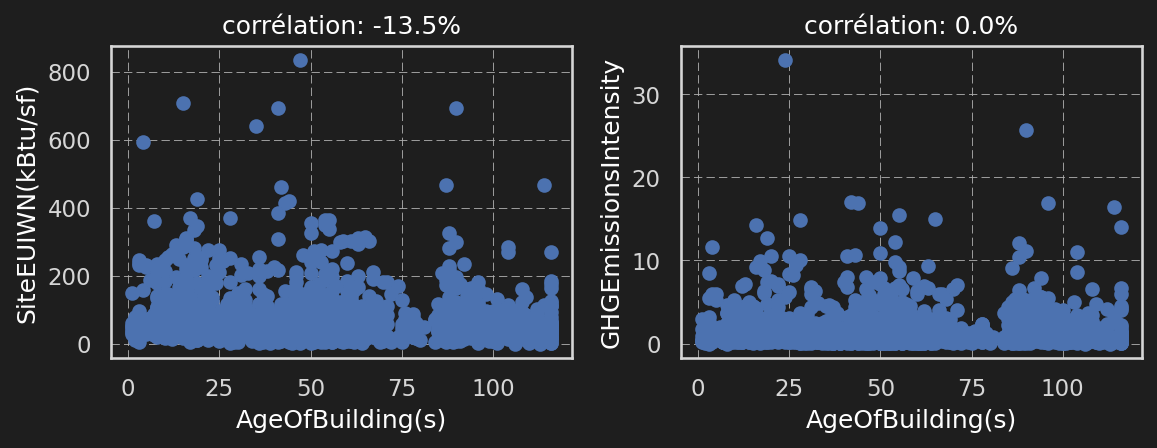

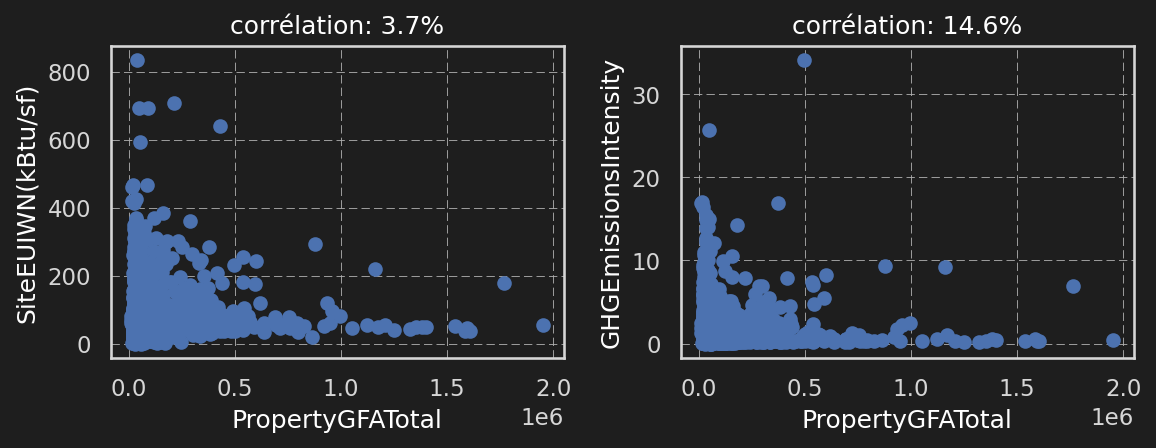

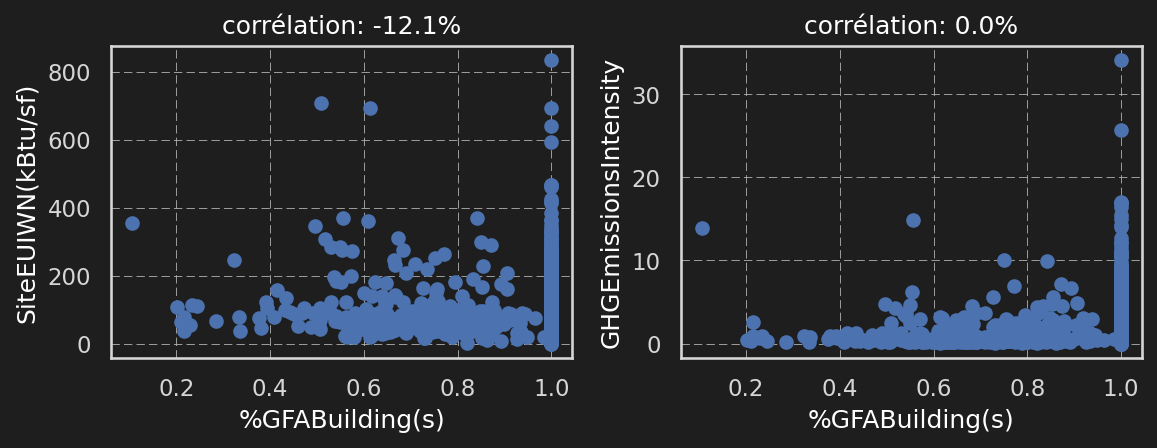

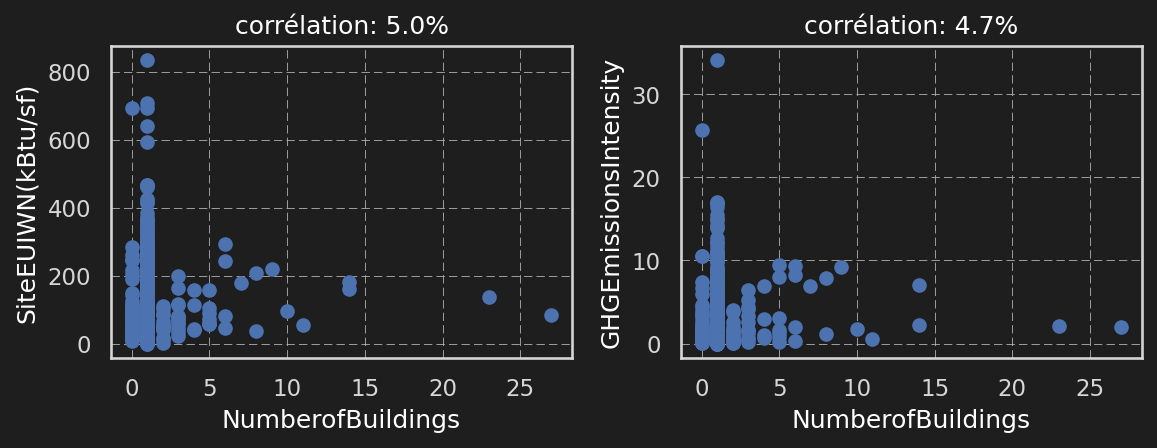

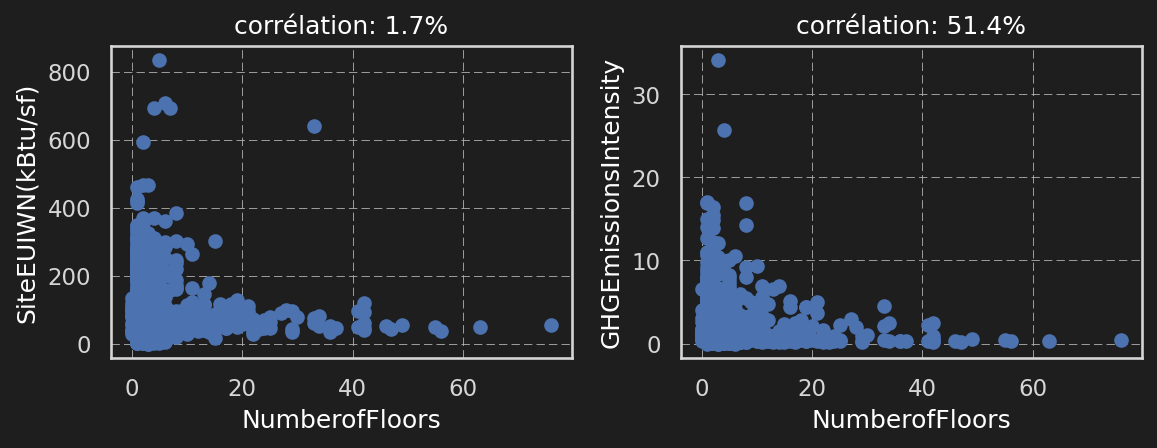

In [82]:
vars = ['AgeOfBuilding(s)', 'PropertyGFATotal',
       '%GFABuilding(s)',
       'NumberofBuildings', 'NumberofFloors']
for var in vars:
    fig, axs = plt.subplots( ncols=2, figsize=(20*cm,8*cm) )
    x,y,y2 = df[[var]+targets].dropna().values.T
    axs[0].plot( x, y, 'bo')
    axs[1].plot( x, y2, 'bo')
    axs[0].set_xlabel(var)
    axs[1].set_xlabel(var)
    axs[0].set_ylabel(targets[0])
    axs[1].set_ylabel(targets[1])
    axs[0].set_title( 'corrélation: {:.1f}%'.format( 100* st.pearsonr(x,y)[0] ) )
    axs[1].set_title( 'corrélation: {:.1f}%'.format( 100* st.pearsonr(x,y)[1] ) )
    fig.tight_layout()

## histogramme / transformation

,AgeOfBuilding(s),PropertyGFATotal,%GFABuilding(s),% use 1,% use 2,% use 3,NumberofBuildings,NumberofFloors
count,1549.000000,1.549000e+03,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,54.606198,1.133162e+05,0.935177,0.854417,0.123706,0.021878,1.107811,4.185926
std,32.880213,1.888695e+05,0.143760,0.185941,0.154914,0.057315,1.197811,6.276183
min,1.000000,1.128500e+04,0.104977,0.333333,0.000000,0.000000,0.000000,0.000000
25%,28.000000,2.880000e+04,1.000000,0.715219,0.000000,0.000000,1.000000,1.000000
50%,51.000000,4.811200e+04,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000
75%,87.000000,1.068600e+05,1.000000,1.000000,0.248363,0.000000,1.000000,4.000000
max,116.000000,1.952220e+06,1.000000,1.000000,0.500000,0.333333,27.000000,76.000000


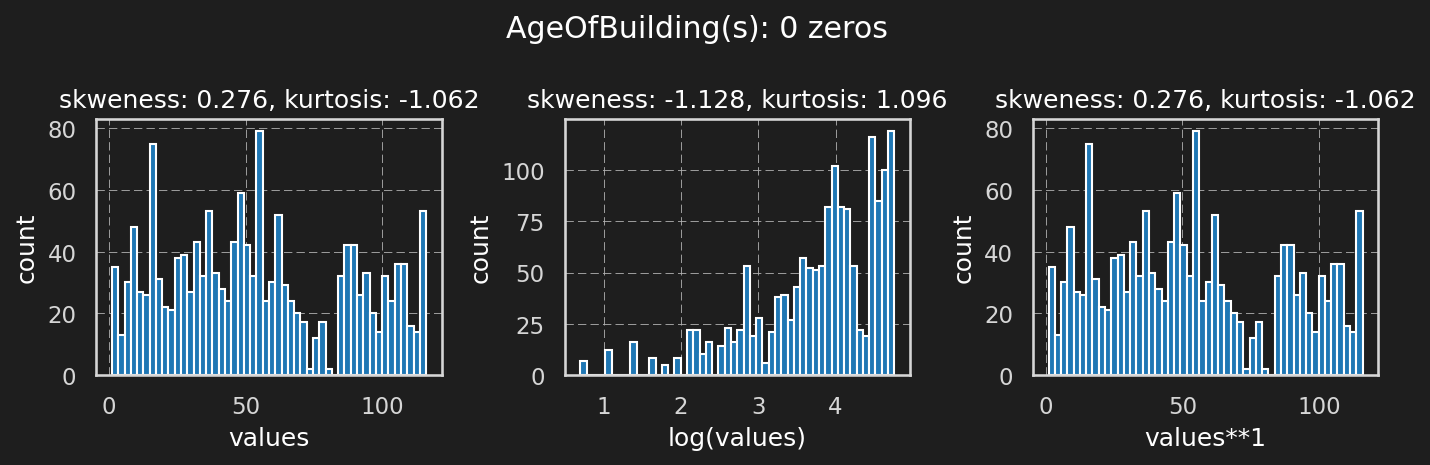

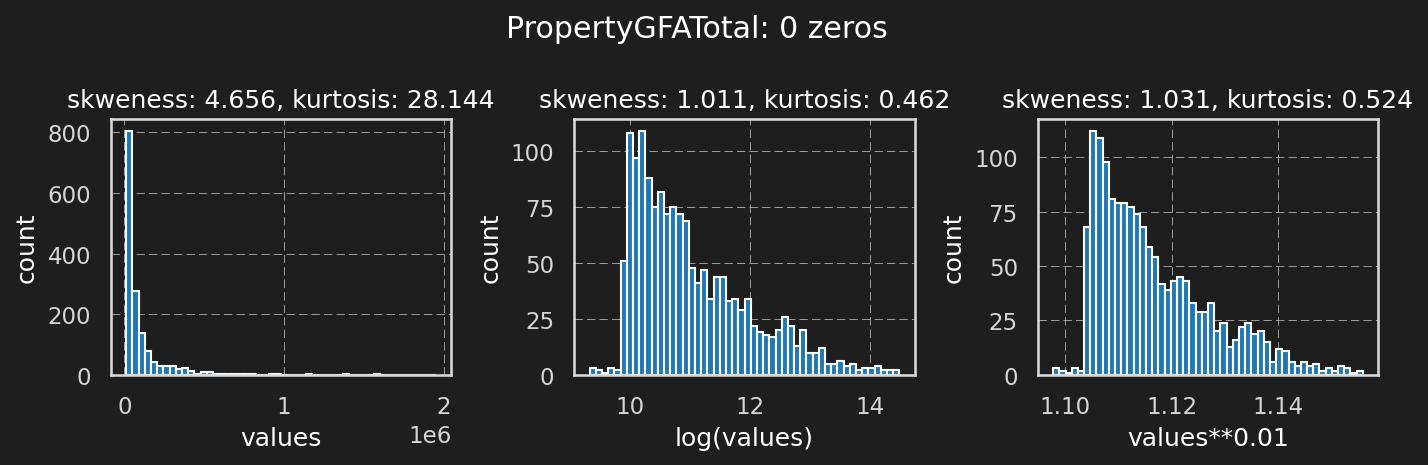

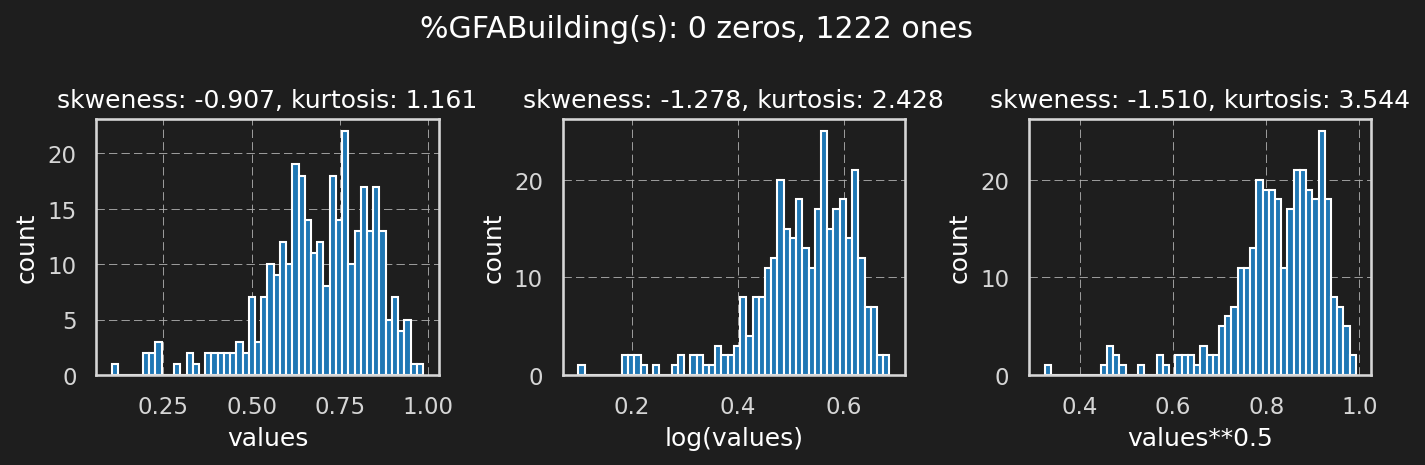

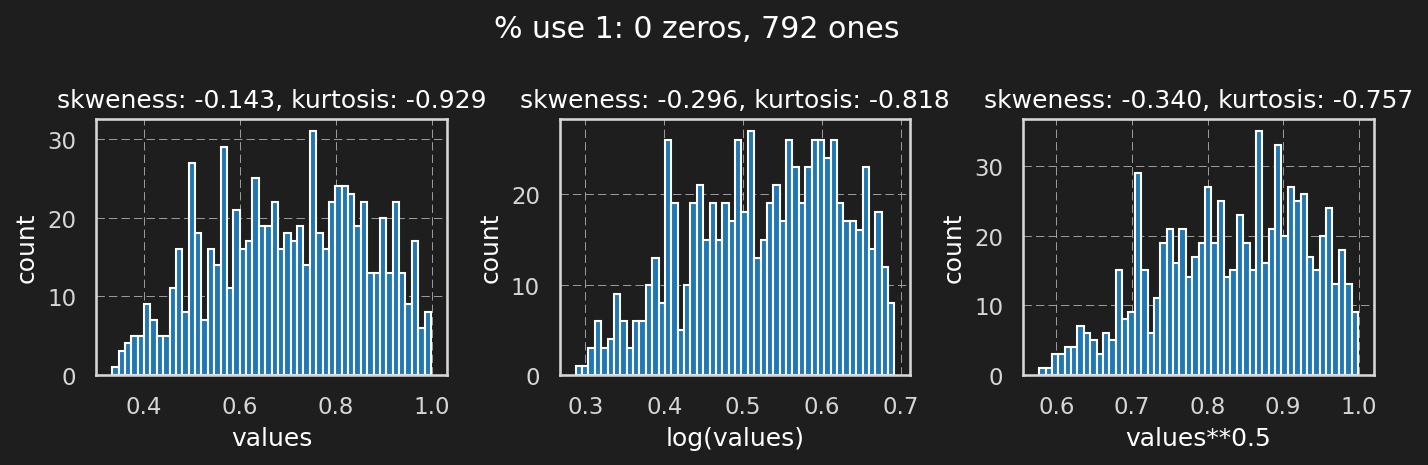

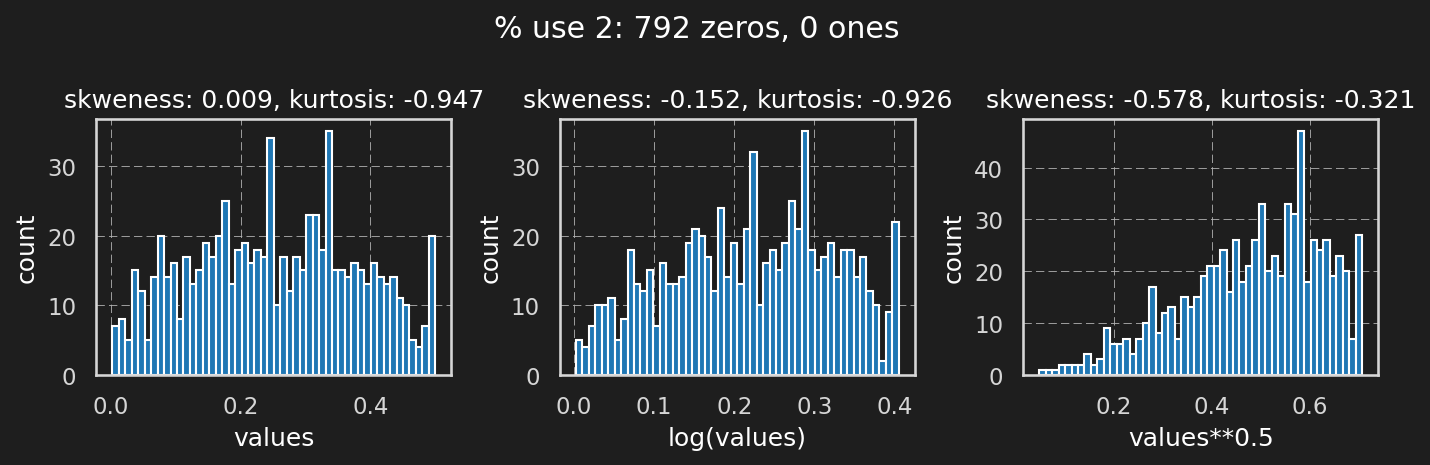

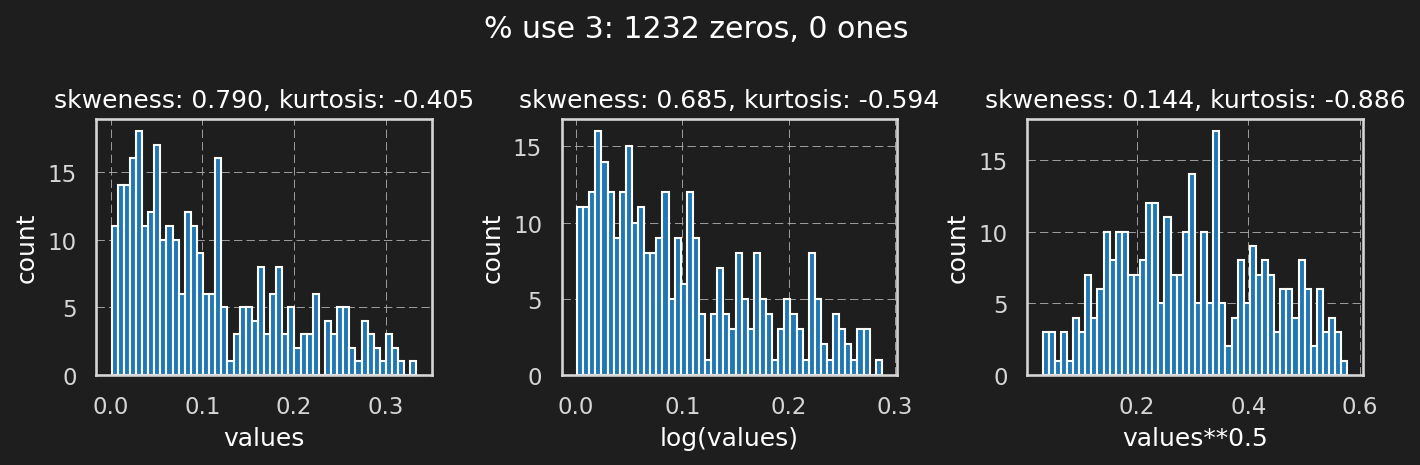

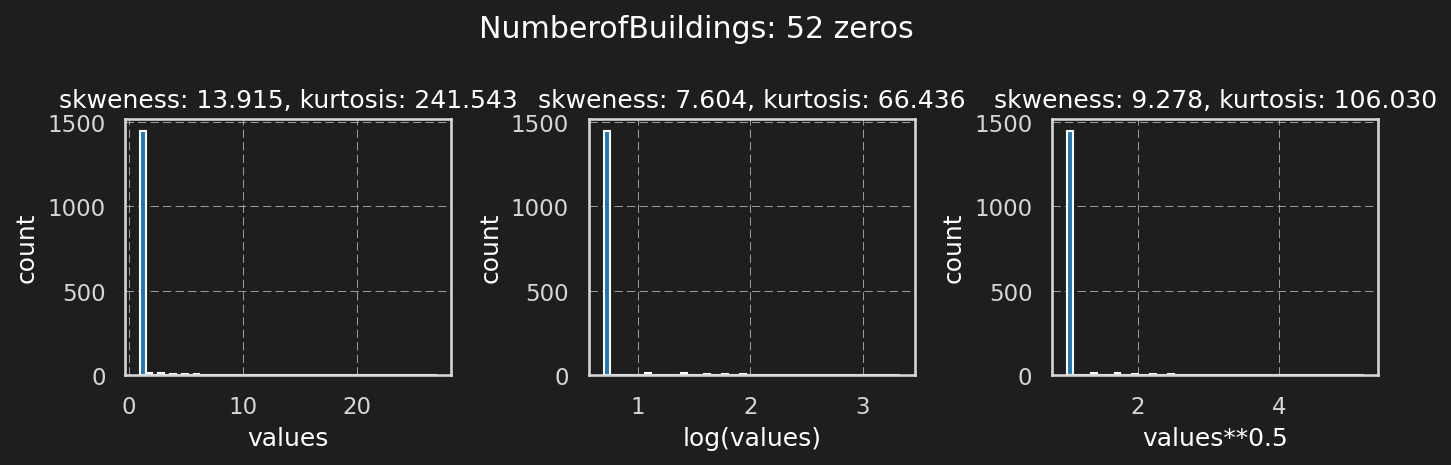

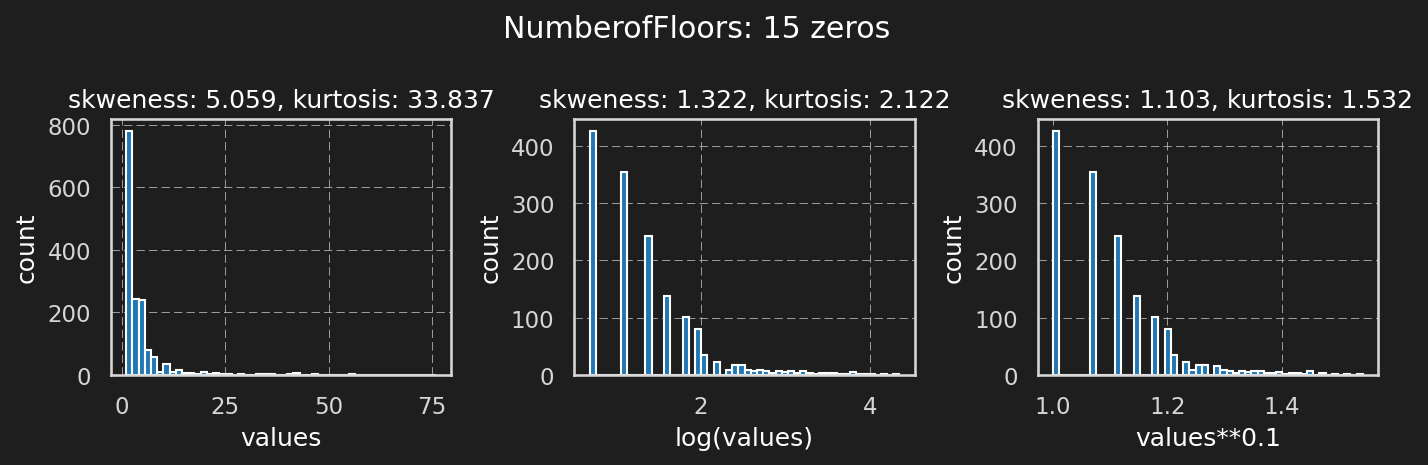

In [83]:
vars = ['AgeOfBuilding(s)', 'PropertyGFATotal',
       '%GFABuilding(s)',
       '% use 1', '% use 2', '% use 3',
       'NumberofBuildings', 'NumberofFloors']

exponents = [1, 0.01, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1]

display( df[vars].describe() )
for var, expo in zip(vars, exponents):
    values = df[var].dropna()
    n_zeros = (values==0).sum()
    values = values[values !=0]
    if '%' in var:
        n_ones = (values==1.).sum()
        values = values[values!=1]
    kurtosis = st.kurtosis( values )
    skew = st.skew( values )

    suptitle = f'{var}: {n_zeros} zeros'
    if '%' in var:
        suptitle += f', {n_ones} ones'
    fig, axs = plt.subplots( ncols=3, figsize=(24*cm,8*cm))
    fig.suptitle( suptitle )
    axs[0].hist( values, bins=50 )
    axs[0].set_xlabel( 'values'  )
    axs[0].set_ylabel( 'count' )
    axs[0].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    values_log = np.log(values + (1 - min(0,values.min())))
    kurtosis = st.kurtosis( values_log )
    skew = st.skew( values_log )
    axs[1].hist( values_log, bins=50 )
    axs[1].set_xlabel( 'log(values)' )
    axs[1].set_ylabel( 'count' )
    axs[1].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    values_pow = values**expo
    kurtosis = st.kurtosis( values_pow )
    skew = st.skew( values_pow )
    axs[2].hist( values_pow, bins=50 )
    axs[2].set_xlabel( f'values**{expo}' )
    axs[2].set_ylabel( 'count' )
    axs[2].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    fig.tight_layout()


In [84]:
features = [ feature for feature in df.columns if not feature in vars_to_delete ]

print( features )

['Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', '%GFABuilding(s)', 'Type use 1', '% use 1', 'Type use 2', '% use 2', 'Type use 3', '% use 3', 'SiteEUIWN(kBtu/sf)', '% SteamUse', '% Electricity', '% NaturalGas', 'Outlier', 'GHGEmissionsIntensity', 'AgeOfBuilding(s)']


## 5.1 OneHotEncoding

In [85]:
value_counts = df['Type use 1'].value_counts().add(
    df['Type use 2'].value_counts(), fill_value=0 ).add(
    df['Type use 3'].value_counts(), fill_value=0 ).astype(int)

PropertyUseTypes = value_counts.index
PropertyUseTypes = PropertyUseTypes.drop( 'parking' ) # valeur redondante avec % GFA Parking ?
print(PropertyUseTypes)

X_propotion_PropertyUseTypeGFA = np.zeros( (len(df), len(PropertyUseTypes)) )
# X_ParkingGFA = np.zeros( len(df) )
for i, index in enumerate(df.index):
    for j in range(1,4) :
        usetype = df.at[index, f'Type use {j}']
        if isinstance( usetype, float ): # test if isnan
            break
        if usetype == 'parking':
            # X_ParkingGFA[i] += df.at[ index, 'LargestPropertyUseTypeGFA']
            continue
        k = PropertyUseTypes.get_loc( usetype )
        X_propotion_PropertyUseTypeGFA[i,k] += df.at[index, f'% use {j}']

Index(['data center', 'education', 'entertainment/public assembly',
       'industrial', 'lifestyle center', 'medical', 'medical office', 'office',
       'other', 'other - entertainment/public assembly', 'residential - hotel',
       'restaurant', 'science', 'self-storage facility', 'services', 'store',
       'utility', 'worship facility'],
      dtype='object')


In [86]:
df_hotencoding_usetype = pd.DataFrame( X_propotion_PropertyUseTypeGFA, columns=PropertyUseTypes, index=df.index )
print( 'DataFrame usetype shape:', df_hotencoding_usetype.shape )
df_hotencoding_usetype.head(10).round(2)

DataFrame usetype shape: (1549, 18)


,data center,education,entertainment/public assembly,industrial,lifestyle center,medical,medical office,office,other,other - entertainment/public assembly,residential - hotel,restaurant,science,self-storage facility,services,store,utility,worship facility
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.81,0.04,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.64,0.00,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
key = 'Neighborhood'
df[key] = df[key].astype('category')
print( df[key].cat.categories )
features_location = df[key].cat.categories.tolist()
X_location = np.zeros( (len(df), len(df[key].cat.categories) ) )
X_location[range(len(df)), df[key].cat.codes] = 1.
df_hotencoding_location = pd.DataFrame( X_location, columns=features_location, index=df.index )

print( 'DataFrame location shape:', df_hotencoding_location.shape )
display(df_hotencoding_location.sample(5) )

Index(['ballard', 'central', 'delridge', 'downtown', 'east',
       'greater duwamish', 'lake union', 'magnolia / queen anne', 'north',
       'northeast', 'northwest', 'southeast', 'southwest'],
      dtype='object')
DataFrame location shape: (1549, 13)


,ballard,central,delridge,downtown,east,greater duwamish,lake union,magnolia / queen anne,north,northeast,northwest,southeast,southwest
303,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3319,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1701,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
print('DataFrame shape:', df.shape )
df.drop( columns= ['Neighborhood', 'Type use 1', '% use 1', 
    'Type use 2', '% use 2', 'Type use 3', '% use 3'], inplace=True )
print('DataFrame shape:', df.shape )

DataFrame shape: (1549, 18)
DataFrame shape: (1549, 11)


In [89]:
df.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       '%GFABuilding(s)', 'SiteEUIWN(kBtu/sf)', '% SteamUse', '% Electricity',
       '% NaturalGas', 'Outlier', 'GHGEmissionsIntensity', 'AgeOfBuilding(s)'],
      dtype='object')

# 6. Sauvegarde

In [90]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

df.to_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
df_annexe.to_pickle( r'{:}{:}_annexe.pkl'.format(path, filename), compression=compression)
df_hotencoding_usetype.to_pickle( r'{:}{:}_usetype.pkl'.format(path, filename), compression=compression)
df_hotencoding_location.to_pickle( r'{:}{:}_location.pkl'.format(path, filename), compression=compression)